In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]
rcParams['grid.color'] = "#0E0E0E30"
rcParams['grid.alpha'] = 0.2

s_palette = sns.cubehelix_palette(as_cmap=True)

In [62]:
from skimage.measure import regionprops_table
from sklearn.cluster import DBSCAN
from skimage.morphology import dilation

datapath = Path().cwd().parent / "data" / "interim" / "confocal" / "emily"

roots = ["m1", "m2", "m3", "m4"]
ncs = ["NC11", "NC12", "NC13", "NC14"]
z_start = {"m1": 2, "m2": 3, "m3": 0, "m4": 0}
a_root = {"m1": (463, 37), "m2": (85, 5), "m3": (22, 23), "m4": (428, 490)}
p_root = {"m1": (70, 475), "m2": (413, 488), "m3": (460, 450), "m4": (83, 10)}

dfs = {}

# quick and dirty
for root in roots:
    rootpath = datapath / root
    rootdfs = []
    for nc in ncs:
        ncfiles = [tifffile.imread(path) for path in list(rootpath.glob(f"*{nc}*.tif"))]
        raw = ncfiles[0][z_start[root]:]
        mask = ncfiles[1][z_start[root]:]
        
        # multiply each z slice of mask by 1000 * z
        # mask = (mask + ((np.arange(mask.shape[0])+1)[:, None, None] * 10000))*(mask > 0)
        
        outside_mask = dilation(mask, np.ones((1, 3, 3)))
        outside_mask = outside_mask * (mask == 0)
        
        tifffile.imwrite(rootpath / f"{nc}_outside_mask.tif", outside_mask)
        
        raw = np.moveaxis(raw, 1, -1)
                       
        df = pd.DataFrame(regionprops_table(mask, intensity_image=raw, properties=('label', 'area', 'centroid', 'mean_intensity', 'bbox')))
        outside_mask_df = pd.DataFrame(regionprops_table(outside_mask, intensity_image=raw, properties=('label', 'area', 'centroid', 'mean_intensity', 'bbox')))
        
        # align df and outside df along label axis
        df = df.set_index("label")
        outside_mask_df = outside_mask_df.set_index("label")        
        
        df["NC ratio (MiniCic)"] = df["mean_intensity-1"] / outside_mask_df["mean_intensity-1"]
        df["NC ratio (HisGFP)"] = df["mean_intensity-0"] / outside_mask_df["mean_intensity-0"]
        df["outside area"] = outside_mask_df["area"]
        
        # rename axes
        df = df.rename(columns={
            "centroid-0": "centroid z",
            "centroid-1": "centroid y",
            "centroid-2": "centroid x",
            "mean_intensity-0": "Mean intensity (HisGFP)",
            "mean_intensity-1": "Mean intensity (MiniCic)",
        })
        
        df["nc"] = nc
        df["root nc"] = f"{root} {nc}"
        
        # calculate AP position
        ax, ay = a_root[root]
        px, py = p_root[root]  
        x, y = df["centroid x"] - ax, df["centroid y"] - ay
        x_ref, y_ref = px - ax, py - ay
        df["ap position"] = (x * x_ref + y * y_ref) / (x_ref ** 2 + y_ref ** 2)
        
        # remove positional outliers
        x = df[["centroid x", "centroid y"]].values
        dbscan = DBSCAN(eps=40, min_samples=1)
        df["position_cluster"] = dbscan.fit_predict(x)
        largest_cluster = df.groupby("position_cluster").size().idxmax()
        df = df[df["position_cluster"] == largest_cluster]
        
        # remove size and intensity outliers
        df = df[(df["area"] > 15) & (df["area"] < 500)]
        df = df[df["Mean intensity (HisGFP)"] > 800]
        
        df["Intensity ratio"] = df["Mean intensity (MiniCic)"] / df["Mean intensity (HisGFP)"]
        a_ir = df[df["ap position"] < 0.1]["Intensity ratio"].mean()
        c_ir = df[(df["ap position"] > 0.45) & (df["ap position"] < 0.55)]["Intensity ratio"].mean()
        
        df["Intensity ratio normalized"] = 1 - (df["Intensity ratio"] - a_ir) / (c_ir - a_ir)
        
        a_ncr = df[df["ap position"] < 0.1]["NC ratio (MiniCic)"].mean()
        c_ncr = df[(df["ap position"] > 0.45) & (df["ap position"] < 0.55)]["NC ratio (MiniCic)"].mean()
        
        df["NC ratio normalized"] = 1 - (df["NC ratio (MiniCic)"] - a_ncr) / (c_ncr - a_ncr)
        
        min_minicic = df["Mean intensity (MiniCic)"].quantile(0.02)
        max_minicic = df["Mean intensity (MiniCic)"].quantile(0.98)
        
        df["Intensity percentile-normalized"] = 1 - (df["Mean intensity (MiniCic)"] - min_minicic) / (max_minicic - min_minicic)
        
        a_ir = df[df["ap position"] < 0.05]["Mean intensity (MiniCic)"].mean()
        c_ir = df[(df["ap position"] > 0.45) & (df["ap position"] < 0.55)]["Mean intensity (MiniCic)"].mean()
        
        df["Intensity normalized"] = 1 - (df["Mean intensity (MiniCic)"] - a_ir) / (c_ir - a_ir)
          
        rootdfs.append(df)
        
    df = pd.concat(rootdfs, ignore_index=True)
    df["root"] = root

    
    dfs[root] = df

df_j = pd.concat(dfs.values(), ignore_index=True)

Exception ignored in: <function ZipFile.__del__ at 0x000001569E782480>
Traceback (most recent call last):
  File "C:\Users\Harrison\.conda\envs\linajea\Lib\zipfile.py", line 1874, in __del__
    self.close()
  File "C:\Users\Harrison\.conda\envs\linajea\Lib\zipfile.py", line 1891, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Exception ignored in: <function ZipFile.__del__ at 0x000001569E782480>
Traceback (most recent call last):
  File "C:\Users\Harrison\.conda\envs\linajea\Lib\zipfile.py", line 1874, in __del__
    self.close()
  File "C:\Users\Harrison\.conda\envs\linajea\Lib\zipfile.py", line 1891, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Exception ignored in: <function ZipFile.__del__ at 0x000001569E782480>
Traceback (most recent call last):
  File "C:\Users\Harrison\.conda\envs\linajea\Lib\zipfile.py", line 1874, in __del__
    self.close()
  File "C:\Users\Harrison\.conda\envs\linajea\Lib\zipfile.py", line 1891, in clo

In [23]:
# for root in roots:
#     nc = "NC14"
#     
#     rootpath = datapath / root
#     ncfiles = [tifffile.imread(path) for path in list(rootpath.glob(f"*{nc}*.tif"))]
#     raw = ncfiles[0][z_start[root]:]
#     
#     z_project = raw.max(axis=0)[0]
#     
#     plt.imshow(z_project, cmap="Greys")
#     
#     plt.scatter([a_root[root][0]], [a_root[root][1]], color=palette["green"], s=30)
#     plt.scatter([p_root[root][0]], [p_root[root][1]], color=palette["pink"], s=30)
#     
#     plt.xticks(np.arange(0, z_project.shape[1], 25))
#     plt.yticks(np.arange(0, z_project.shape[0], 25))
#     
#     plt.savefig(datapath / f"{root}_axis.png", dpi=300)
#     
#     plt.show()

In [63]:
df_j.columns

Index(['area', 'centroid z', 'centroid y', 'centroid x',
       'Mean intensity (HisGFP)', 'Mean intensity (MiniCic)', 'bbox-0',
       'bbox-1', 'bbox-2', 'bbox-3', 'bbox-4', 'bbox-5', 'NC ratio (MiniCic)',
       'NC ratio (HisGFP)', 'outside area', 'nc', 'root nc', 'ap position',
       'position_cluster', 'Intensity ratio', 'Intensity ratio normalized',
       'NC ratio normalized', 'Intensity percentile-normalized',
       'Intensity normalized', 'root'],
      dtype='object')

In [68]:
from collections import defaultdict

n_bins = 20
bins = np.linspace(0, 1, n_bins+1, endpoint=True)
df_j["binned_ap"] = pd.cut(df_j["ap position"], bins=bins, right=True)
df_j = df_j.dropna().copy().sort_values(by="binned_ap")
df_j["binned_ap"] = df_j["binned_ap"].apply(lambda x: round((x.left + x.right) / 2, 2))

stats = ["Intensity ratio", "Intensity ratio normalized", 
         "Mean intensity (MiniCic)", "Intensity normalized", 
         "NC ratio (MiniCic)", "NC ratio normalized"]

nc_values = defaultdict(dict)
nc_root_values = defaultdict(dict)
nc_counts = {}
nc_root_counts = {}


for nc in ncs:
    stat_replicates = defaultdict(list)
    for root in roots:
        df = df_j[(df_j.root == root) & (df_j.nc == nc)]
        
        nc_root_counts[f"{root} {nc}"] = df.groupby("binned_ap", observed=True).size()
        
        for stat in stats:
            stat_replicates[stat].append(df.groupby("binned_ap", observed=True)[stat].mean())
            nc_root_values[stat][f"{root} {nc}"] = df.groupby("binned_ap", observed=True)[stat].mean()
    
    nc_counts[nc] = df_j[df_j.nc == nc].groupby("binned_ap", observed=True).size()
     
    for stat in stats:   
        nc_values[stat][nc] = pd.concat(stat_replicates[stat], axis=1).mean(axis=1)
    
with pd.ExcelWriter(datapath / "nc_stats.xlsx") as writer:
    for stat in stats:
        writer.book.create_sheet(stat)
        df = pd.DataFrame(nc_values[stat])
        df.to_excel(writer, sheet_name=stat)
        
    df = pd.DataFrame(nc_counts)
    df.to_excel(writer, sheet_name="counts")
        
with pd.ExcelWriter(datapath / "nc_stats_by_movie.xlsx") as writer:
    for stat in stats:
        df = pd.DataFrame(nc_root_values[stat])
        df.to_excel(writer, sheet_name=f"{stat}")
        
    df = pd.DataFrame(nc_root_counts)
    df.to_excel(writer, sheet_name="counts")

In [9]:
gated = df_j.copy()
gated["binned_ap"] = [(i.left + i.right) / 2 for i in pd.cut(gated["ap position"], bins=20)]
gated

area  centroid z  centroid y  centroid x  Mean intensity (HisGFP)  \
0      104.0    0.355769  100.028846  351.067308              1558.259615   
1       95.0    0.305263   99.515789  391.863158              1594.326316   
2      109.0    0.357798  111.596330  402.183486              1575.073394   
3       68.0    0.000000  114.205882  308.691176              1589.955882   
4       66.0    0.000000  120.893939  355.575758              1583.757576   
...      ...         ...         ...         ...                      ...   
18433   42.0   12.000000  496.142857  350.000000              1958.261905   
18434   48.0   12.000000  496.416667  408.208333              2007.520833   
18435   26.0   12.000000  496.346154  415.115385              2127.192308   
18436   48.0   12.000000  498.604167  395.541667              2150.895833   
18437   38.0   12.000000  499.763158  387.447368              1997.605263   

       Mean intensity (MiniCic)  bbox-0  bbox-1  bbox-2  bbox-3  ...  root nc  \
0                    434.798077       0      96     347       2  ...  m1 NC11   
1                    354.168421       0      96     388       2  ...  m1 NC11   
2                    370.972477       0     107     398       2  ...  m1 NC11   
3                    555.338235       0     110     305       1  ...  m1 NC11   
4                    481.212121       0     117     351       1  ...  m1 NC11   
...                         ...     ...     ...     ...     ...  ...      ...   
18433                498.238095      12     492     347      13  ...  m4 NC14   
18434                247.729167      12     493     405      13  ...  m4 NC14   
18435                208.576923      12     494     413      13  ...  m4 NC14   
18436                282.687500      12     495     392      13  ...  m4 NC14   
18437                298.710526      12     497     384      13  ...  m4 NC14   

       ap position  position_cluster  Intensity Ratio  Erk Activity  \
0         0.208939                 0         0.279028      0.639471   
1         0.164302                 0         0.222143      0.852802   
2         0.167577                 0         0.235527      0.802609   
3         0.271584                 0         0.349279      0.376014   
4         0.228967                 0         0.303842      0.546413   
...            ...               ...              ...           ...   
18433     0.081939                 0         0.254429      0.633853   
18434     0.025983                 0         0.123401      1.073601   
18435     0.019481                 0         0.098053      1.158672   
18436     0.035150                 0         0.131428      1.046660   
18437     0.041328                 0         0.149534      0.985892   

      NC Normalized Minicic Normalized  Minicic Positional Normed  root  \
0          0.318030           0.543374                   0.487978    m1   
1          0.590573           0.687884                   0.651301    m1   
2          0.414503           0.657767                   0.617262    m1   
3          0.075070           0.327335                   0.243813    m1   
4          0.336348           0.460188                   0.393962    m1   
...             ...                ...                        ...   ...   
18433      0.665883           0.774347                   0.845050    m4   
18434      1.127383           0.969147                   1.117614    m4   
18435      1.248062           0.999593                   1.160213    m4   
18436      1.024239           0.941963                   1.079578    m4   
18437      1.128097           0.929503                   1.062144    m4   

       binned_ap  
0       0.231500  
1       0.182500  
2       0.182500  
3       0.281000  
4       0.231500  
...          ...  
18433   0.084450  
18434   0.034845  
18435   0.034845  
18436   0.034845  
18437   0.034845  

[18438 rows x 26 columns]

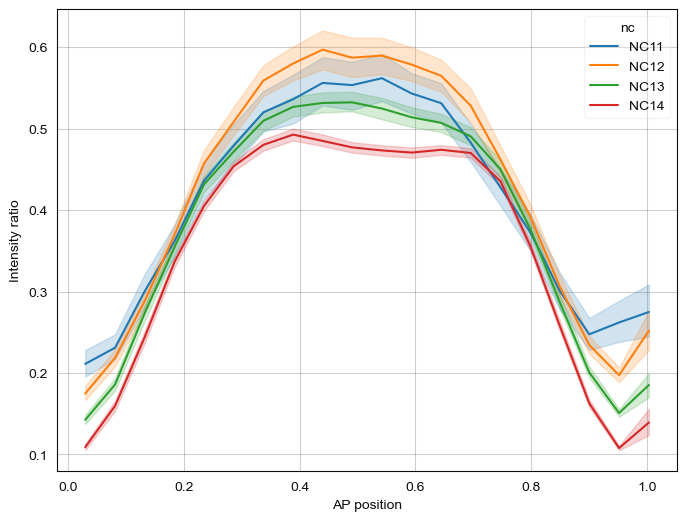

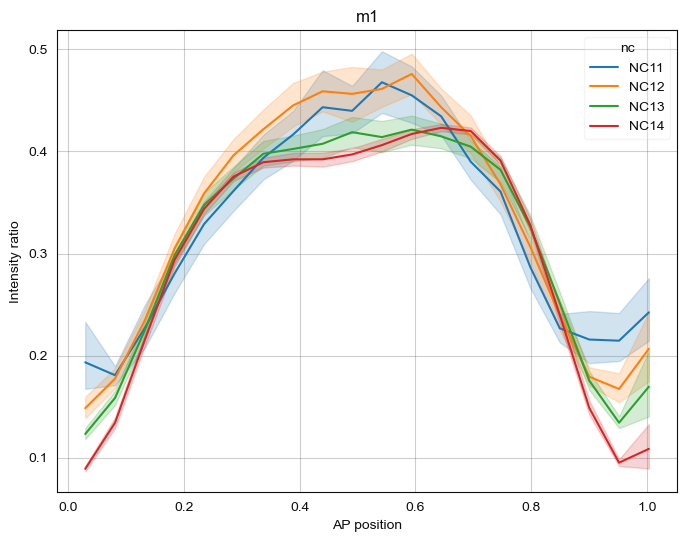

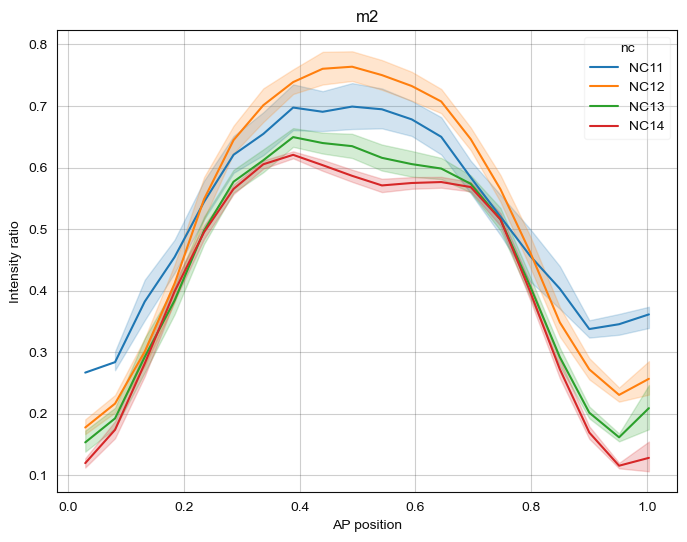

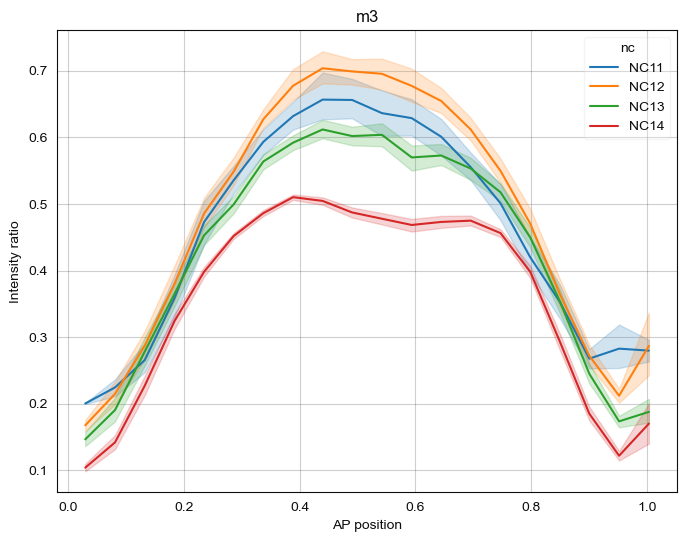

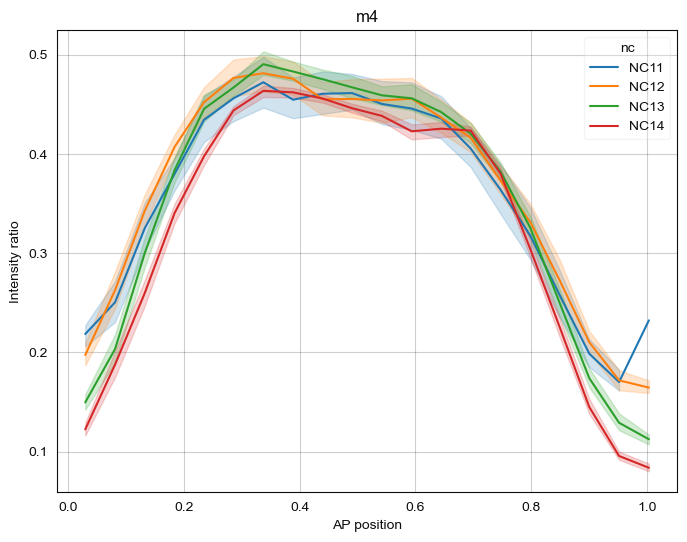

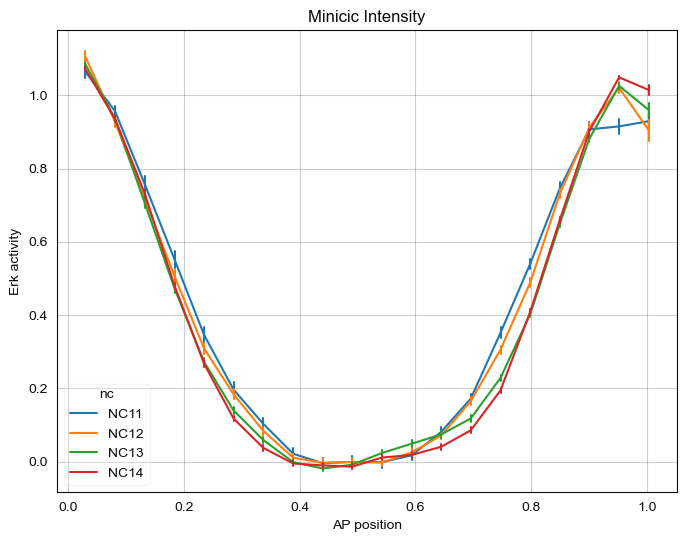

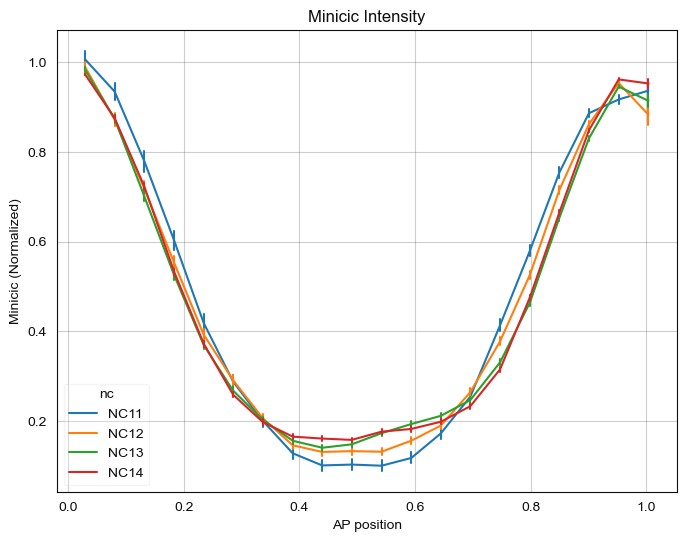

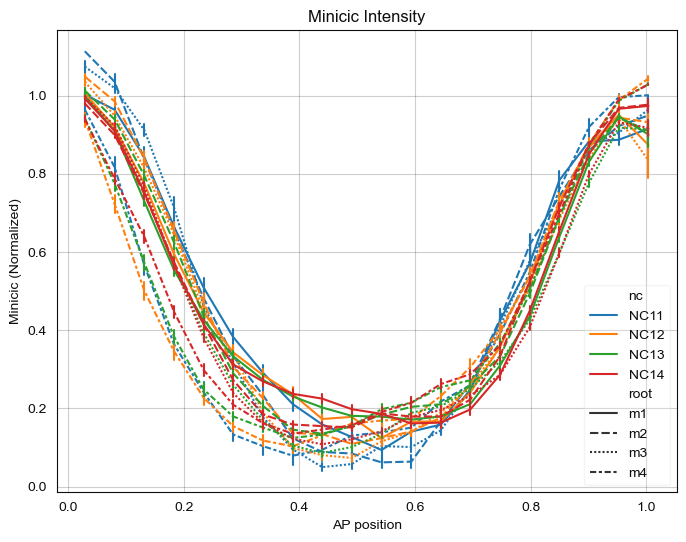

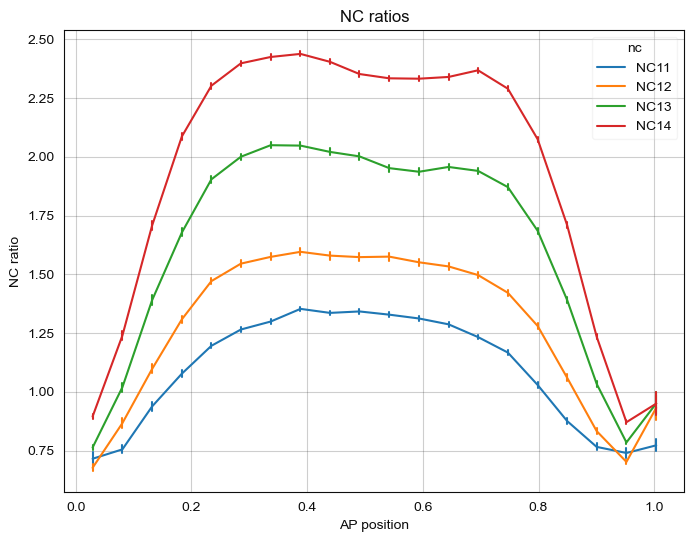

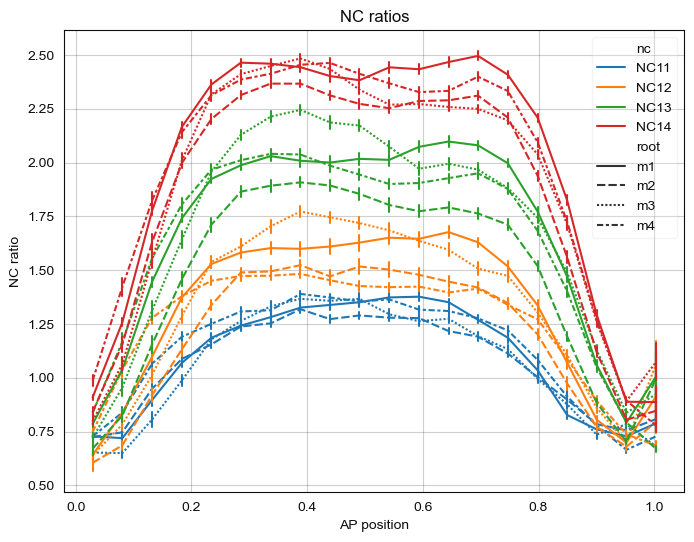

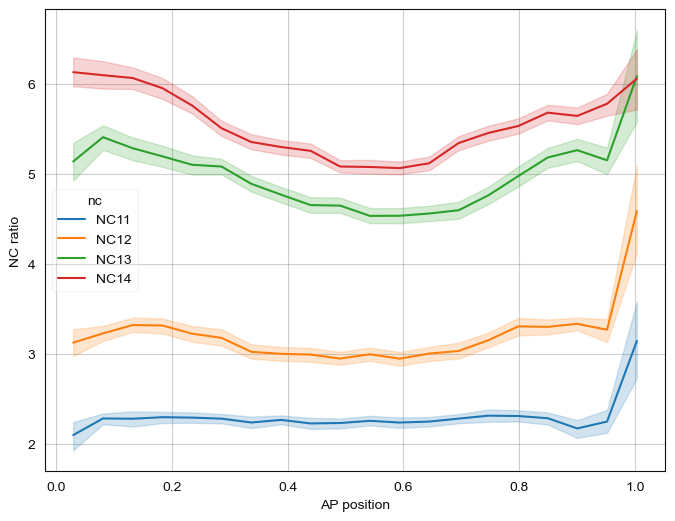

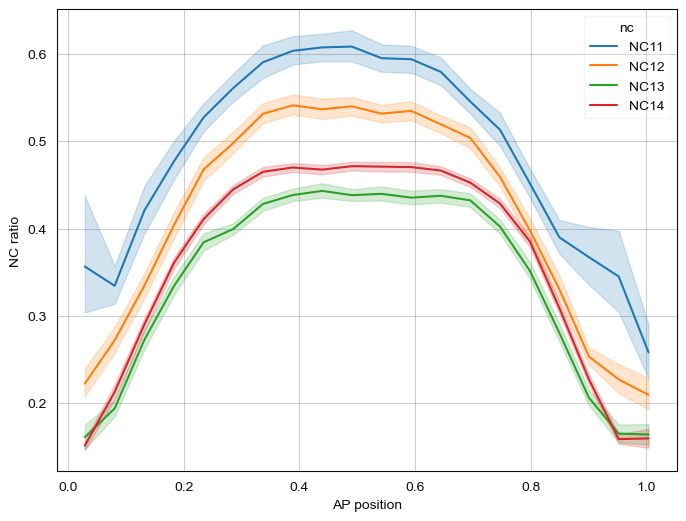

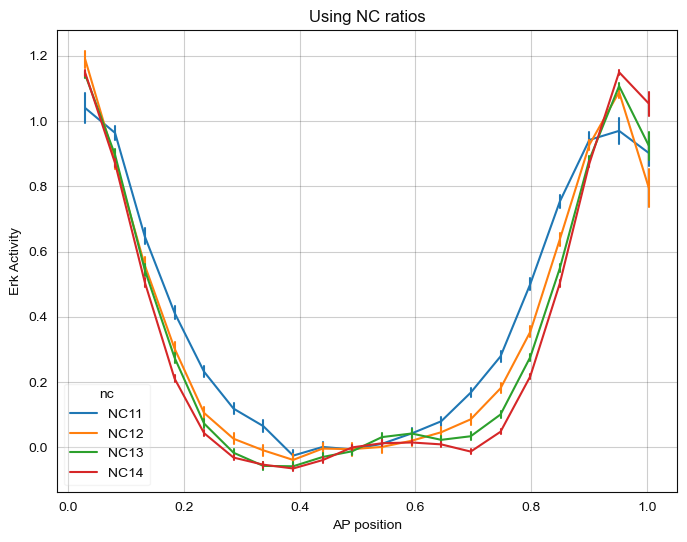

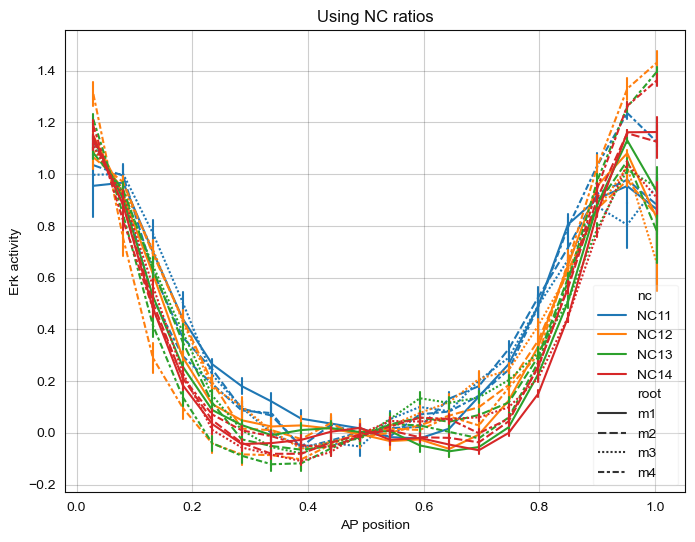

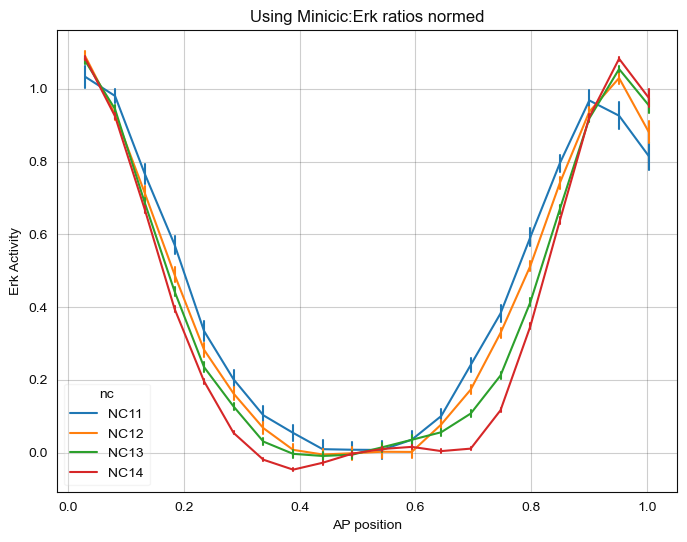

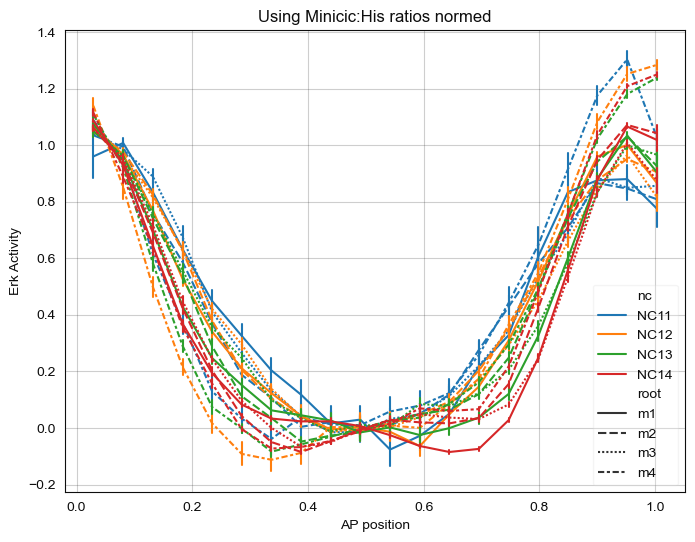

In [22]:
gated = df_j.copy()
gated["binned_ap"] = [(i.left + i.right) / 2 for i in pd.cut(gated["ap position"], bins=20)]
gated["ratio ratio"] = gated["NC ratio (MiniCic)"] / gated["NC ratio (HisGFP)"]

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Intensity Ratio", hue="nc")
plt.xlabel("AP position")
plt.ylabel("Intensity ratio")
plt.savefig(datapath / "ap_intensity.png", dpi=300)
plt.show()

for root in roots:
    fig, ax = plt.subplots(figsize=(8, 6))
    df = gated[gated.root == root]
    sns.lineplot(df, x="binned_ap", y="Intensity Ratio", hue="nc")
    plt.xlabel("AP position")
    plt.ylabel("Intensity ratio")
    plt.title(root)
    plt.savefig(datapath / root / f"ap_intensity.png", dpi=300)
    plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Minicic Positional Normed", hue="nc", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("Erk activity")
plt.title("Minicic Intensity")
plt.savefig(datapath / "positional_minicic_intensity.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Minicic Normalized", hue="nc", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("Minicic (Normalized)")
plt.title("Minicic Intensity")
plt.savefig(datapath / "minicic_intensity.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Minicic Normalized", hue="nc", style="root", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("Minicic (Normalized)")
plt.title("Minicic Intensity")
plt.savefig(datapath / "root_minicic_intensity.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="NC ratio (MiniCic)", hue="nc", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("NC ratio")
plt.title("NC ratios")
plt.savefig(datapath / "nc_ratio.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="NC ratio (MiniCic)", hue="nc", style="root", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("NC ratio")
plt.title("NC ratios")
plt.savefig(datapath / "root_nc_ratio.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="NC ratio (HisGFP)", hue="nc")
plt.xlabel("AP position")
plt.ylabel("NC ratio")
plt.savefig(datapath / "his_nc_ratio.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="ratio ratio", hue="nc")
plt.xlabel("AP position")
plt.ylabel("NC ratio")
plt.savefig(datapath / "nc_ratio_ratio.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="NC Normalized", hue="nc", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("Erk Activity")
plt.title("Using NC ratios")
plt.savefig(datapath / "nc_ratio_normed.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="NC Normalized", hue="nc", style="root", err_style="bars", errorbar="se")
plt.xlabel("AP position")
plt.ylabel("Erk activity")
plt.title("Using NC ratios")
plt.savefig(datapath / "byroot_nc_ratio_normed.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Erk Activity", hue="nc", err_style="bars", errorbar="se")
plt.xlabel("AP position")
# plt.ylabel("Intensity ratio")
plt.title("Using Minicic:Erk ratios normed")
plt.savefig(datapath / "erk_activity.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Erk Activity", hue="nc", style="root", err_style="bars", errorbar="se")
plt.xlabel("AP position")
# plt.ylabel("Intensity ratio")
plt.title("Using Minicic:His ratios normed")
plt.savefig(datapath / "root erk_activity.png", dpi=300)
plt.show()
# 
# for root in roots:
#     fig, ax = plt.subplots(figsize=(8, 6))
#     df = gated[gated.root == root]
#     sns.lineplot(df, x="binned_ap", y="NC ratio (MiniCic)", hue="nc")
#     plt.xlabel("AP position")
#     plt.ylabel("NC ratio")
#     plt.title(f"{root} MiniCic NC ratio")
#     plt.savefig(datapath / root / f"nc_ratio.png", dpi=300)
#     plt.show()

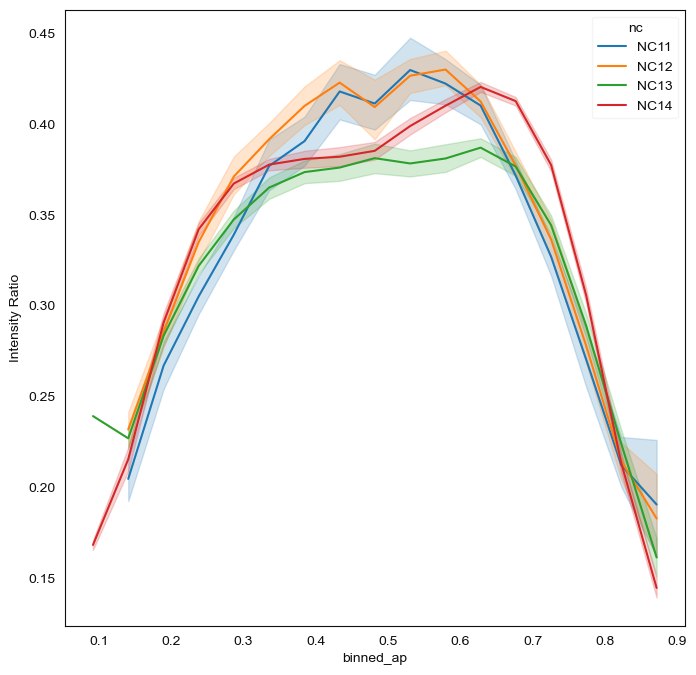

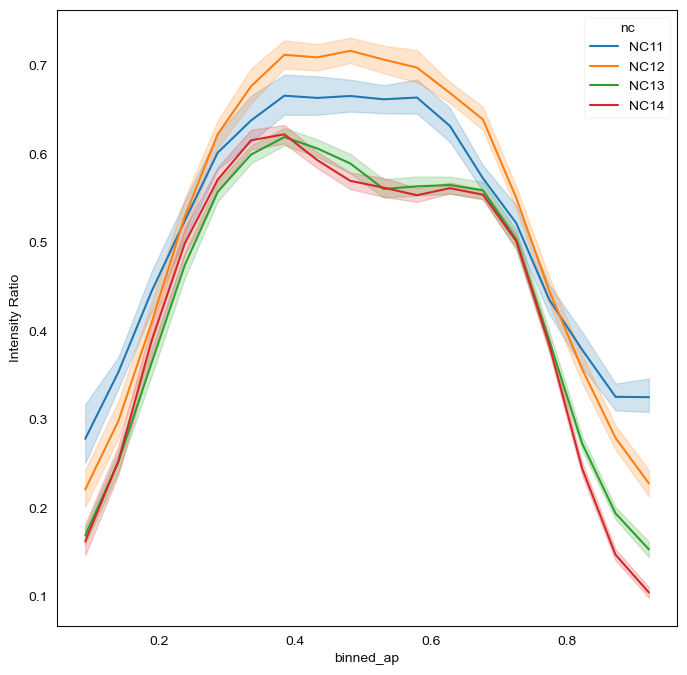

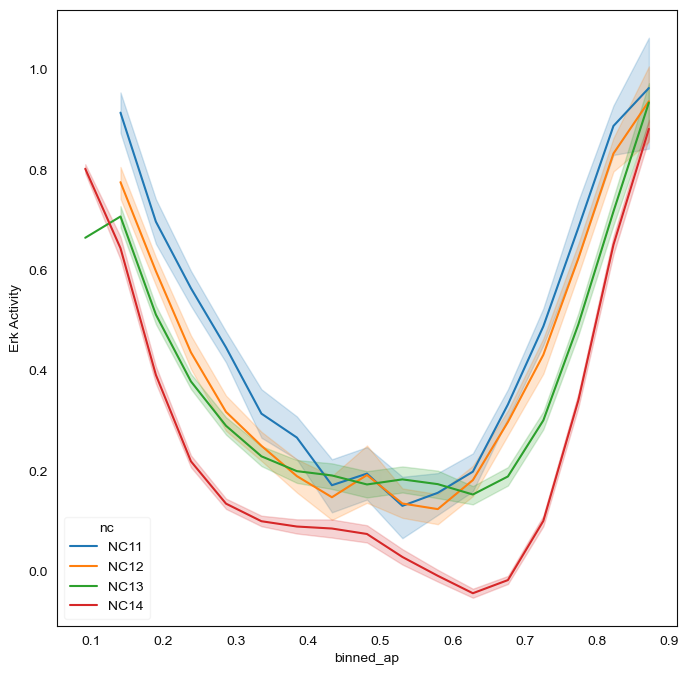

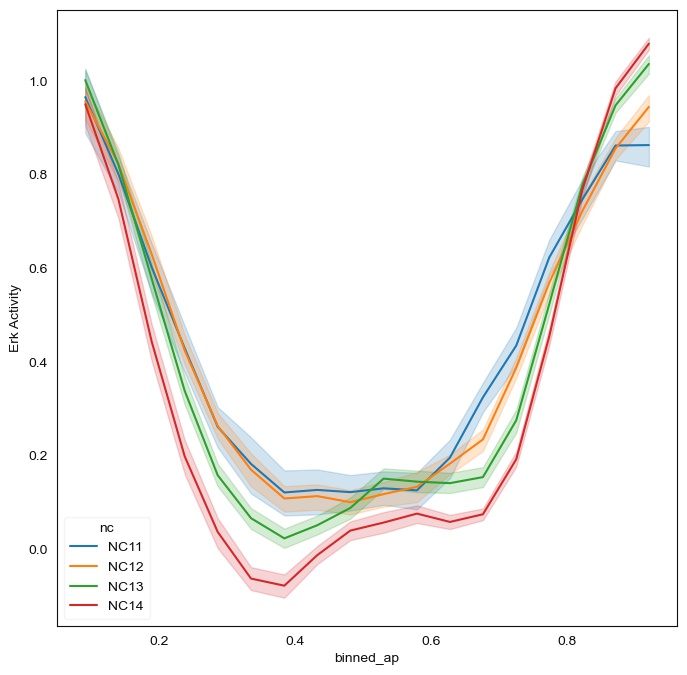

In [58]:
for root in roots:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    df = gated[(gated.root == root) & (gated["centroid z"] <= 3)]
    
    sns.lineplot(df, x="binned_ap", y="Intensity Ratio", hue="nc", ax=ax)
    plt.show()
    
for root in roots:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    df = gated[(gated.root == root) & (gated["centroid z"] <= 3)]
    
    sns.lineplot(df, x="binned_ap", y="Erk Activity", hue="nc", ax=ax)
    plt.show()

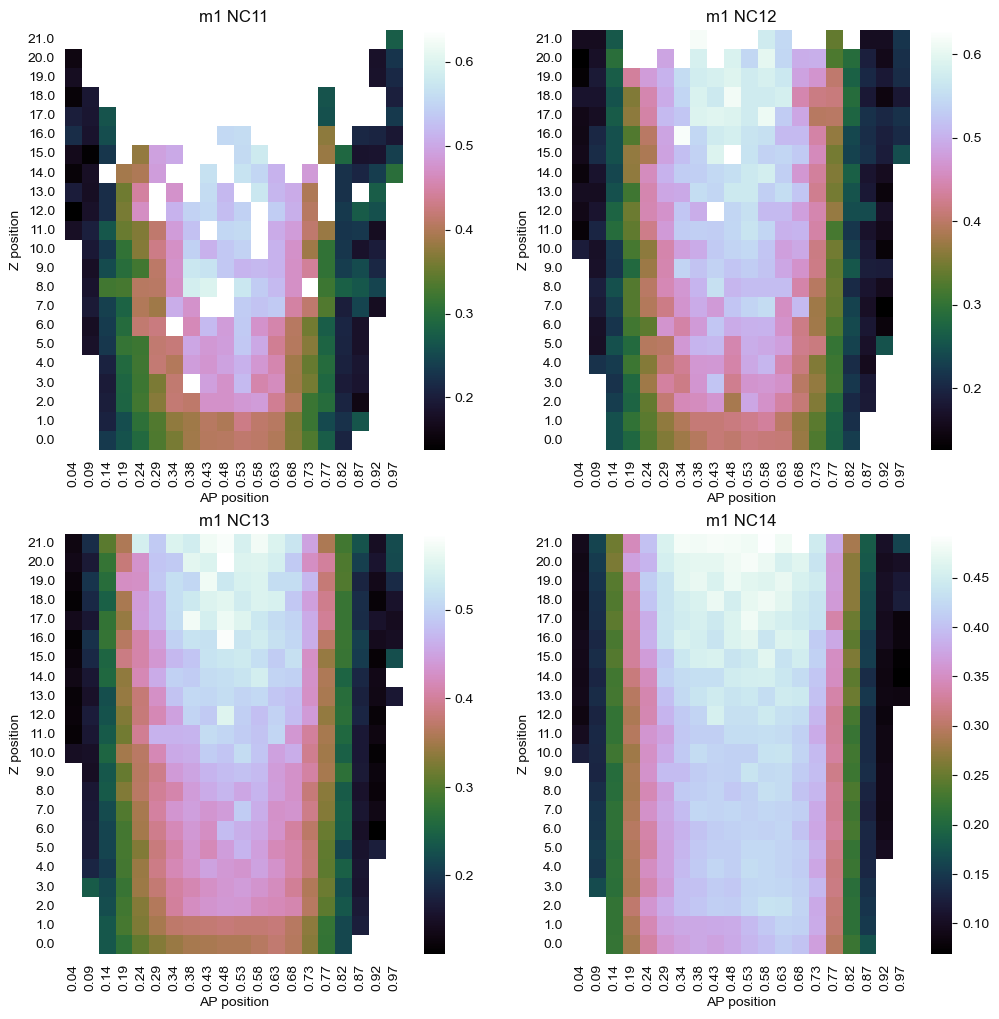

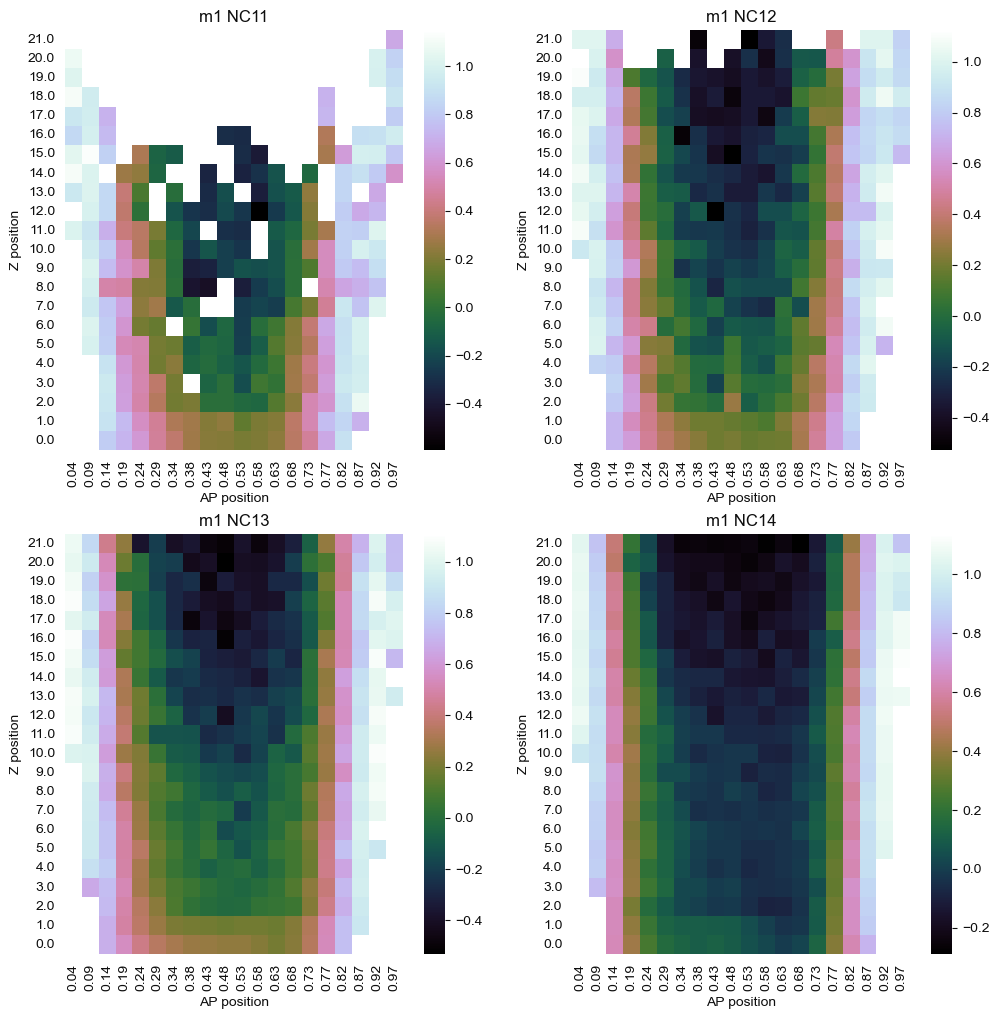

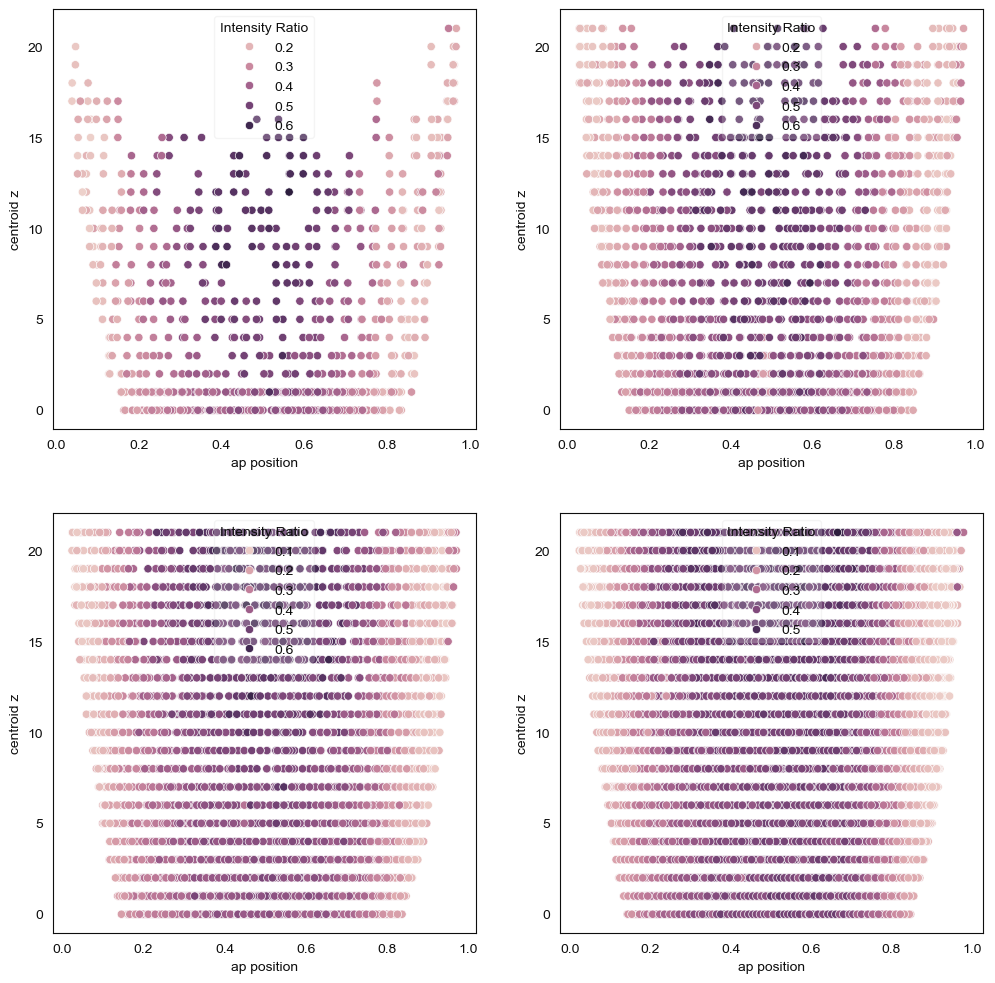

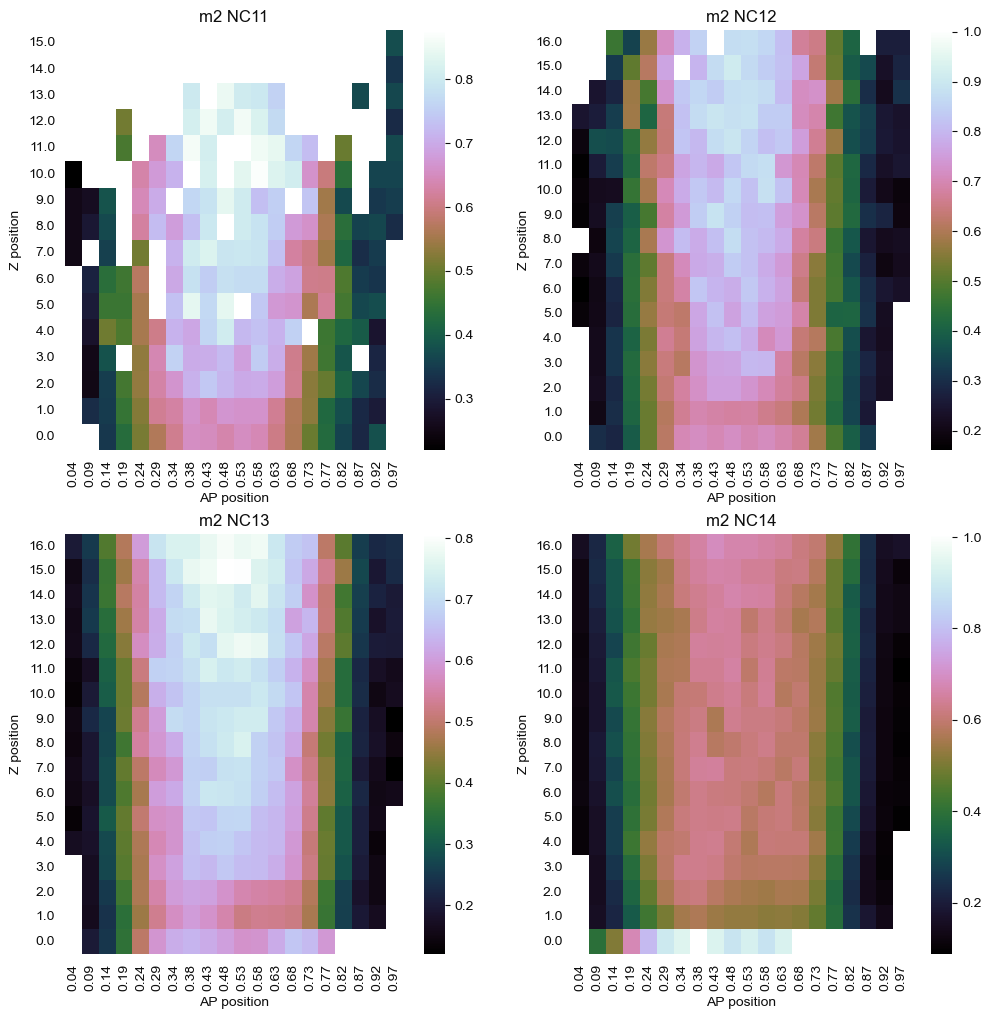

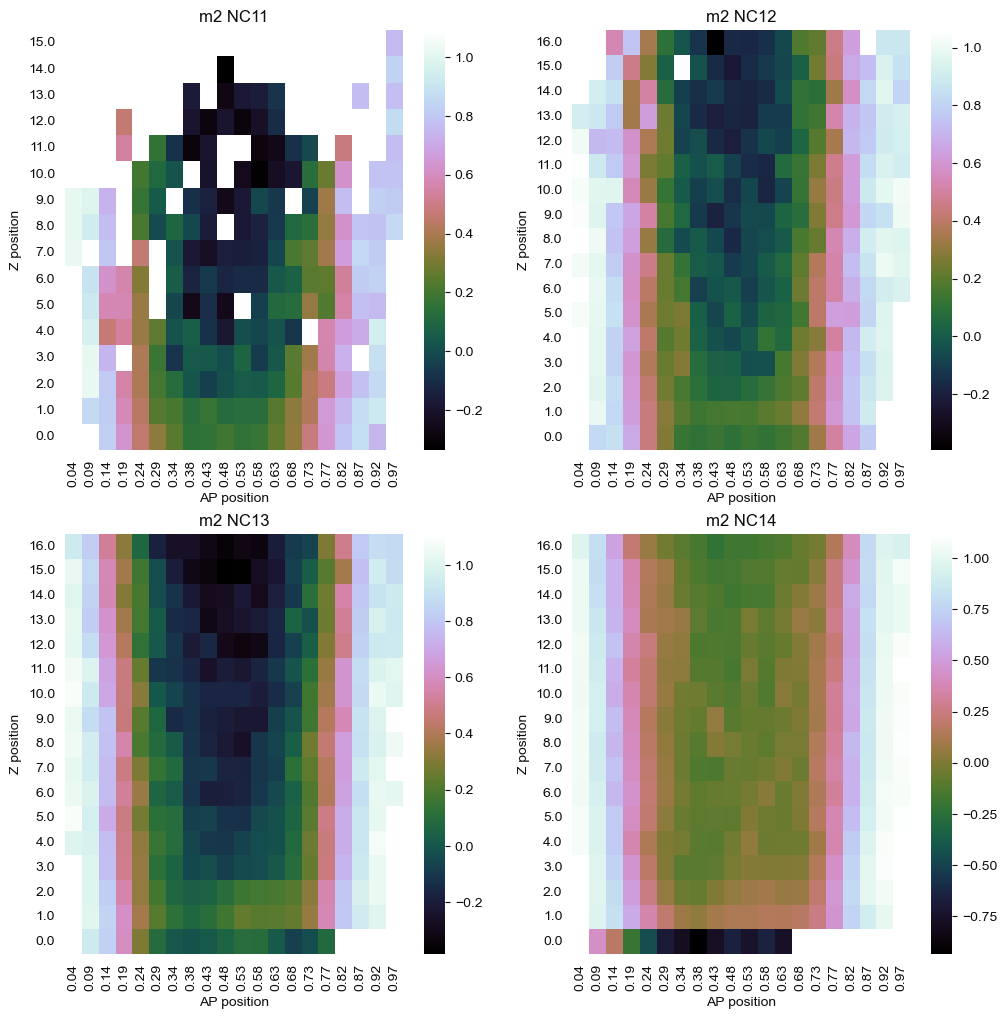

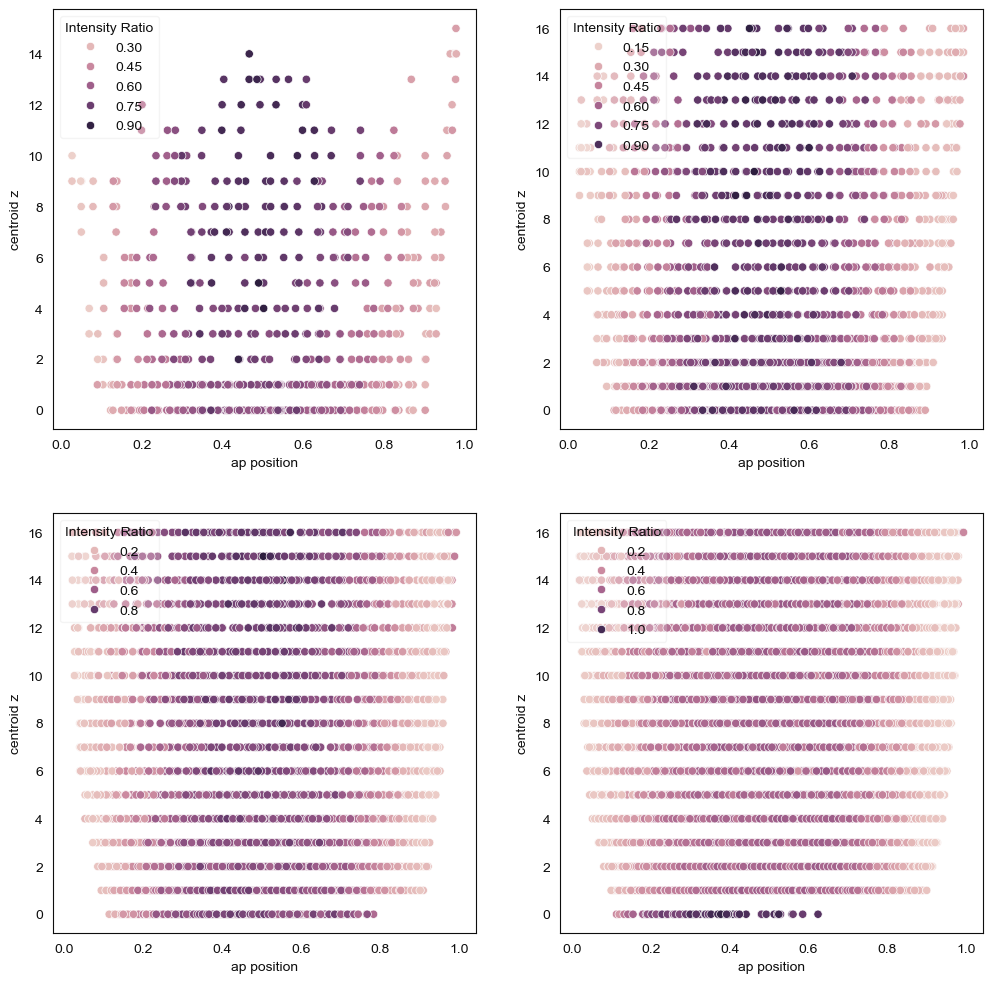

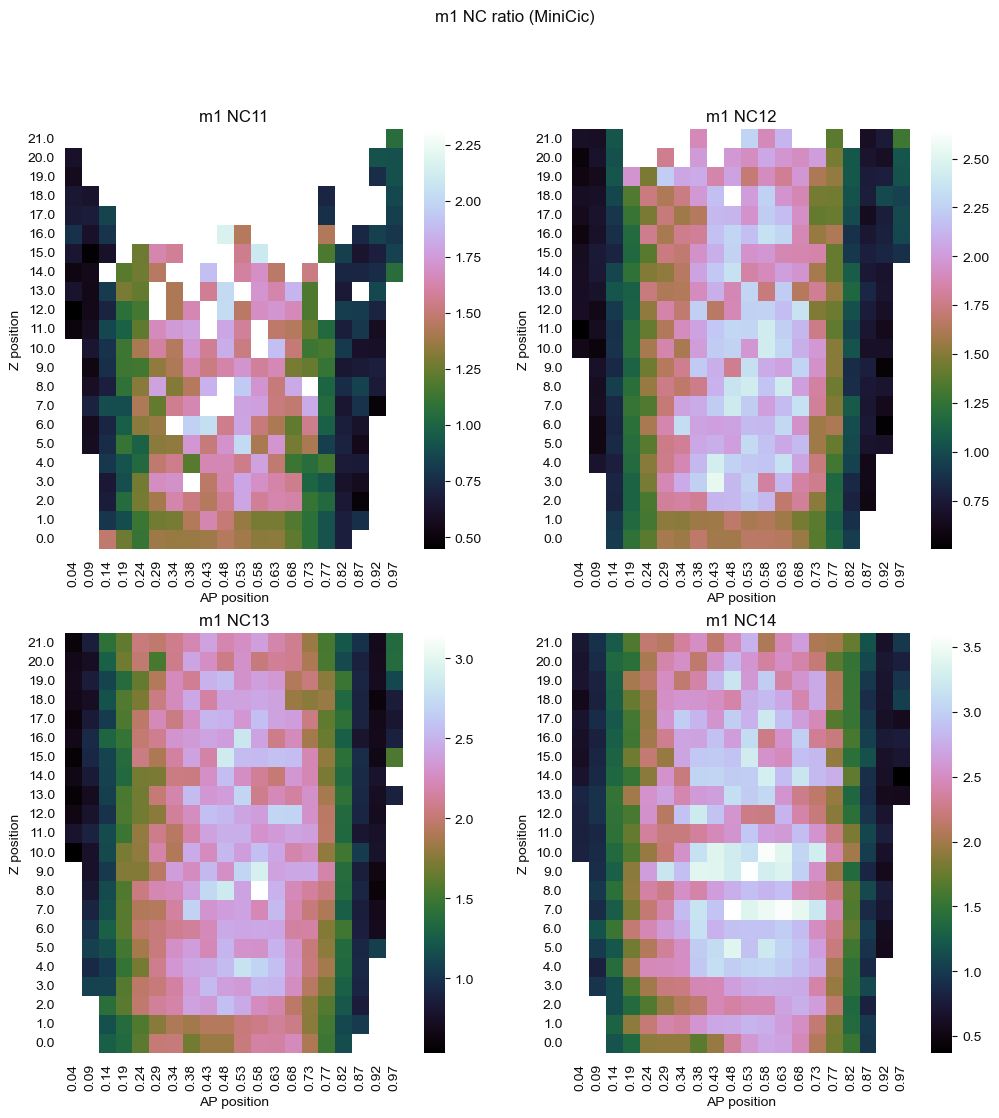

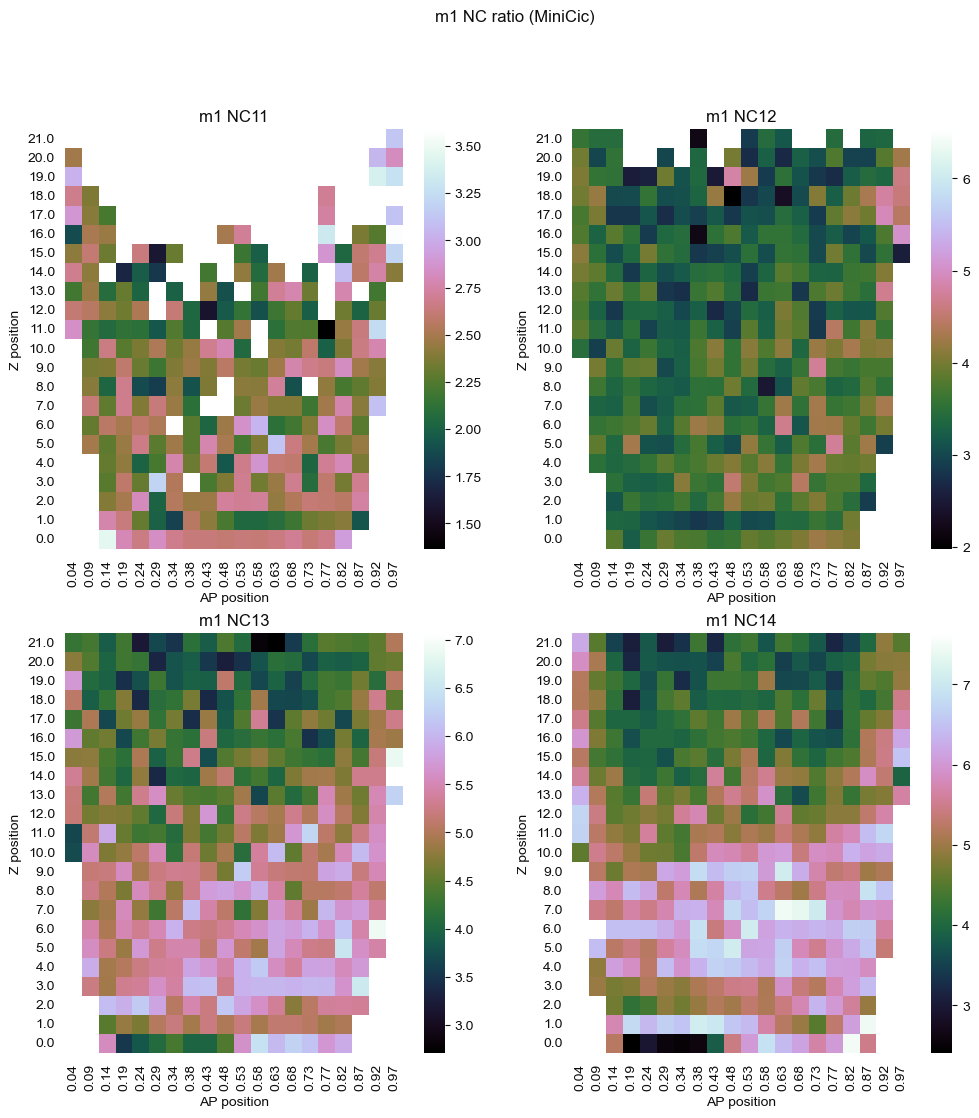

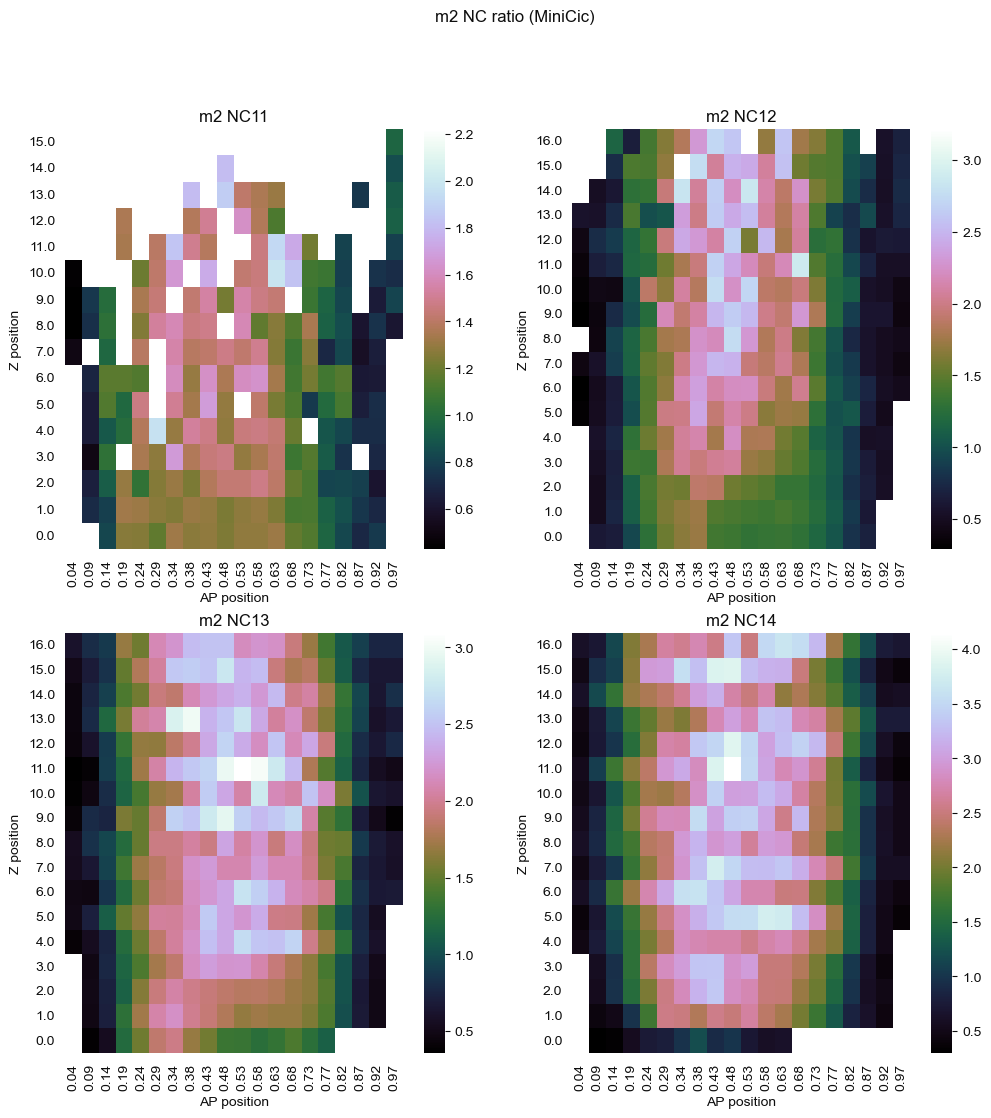

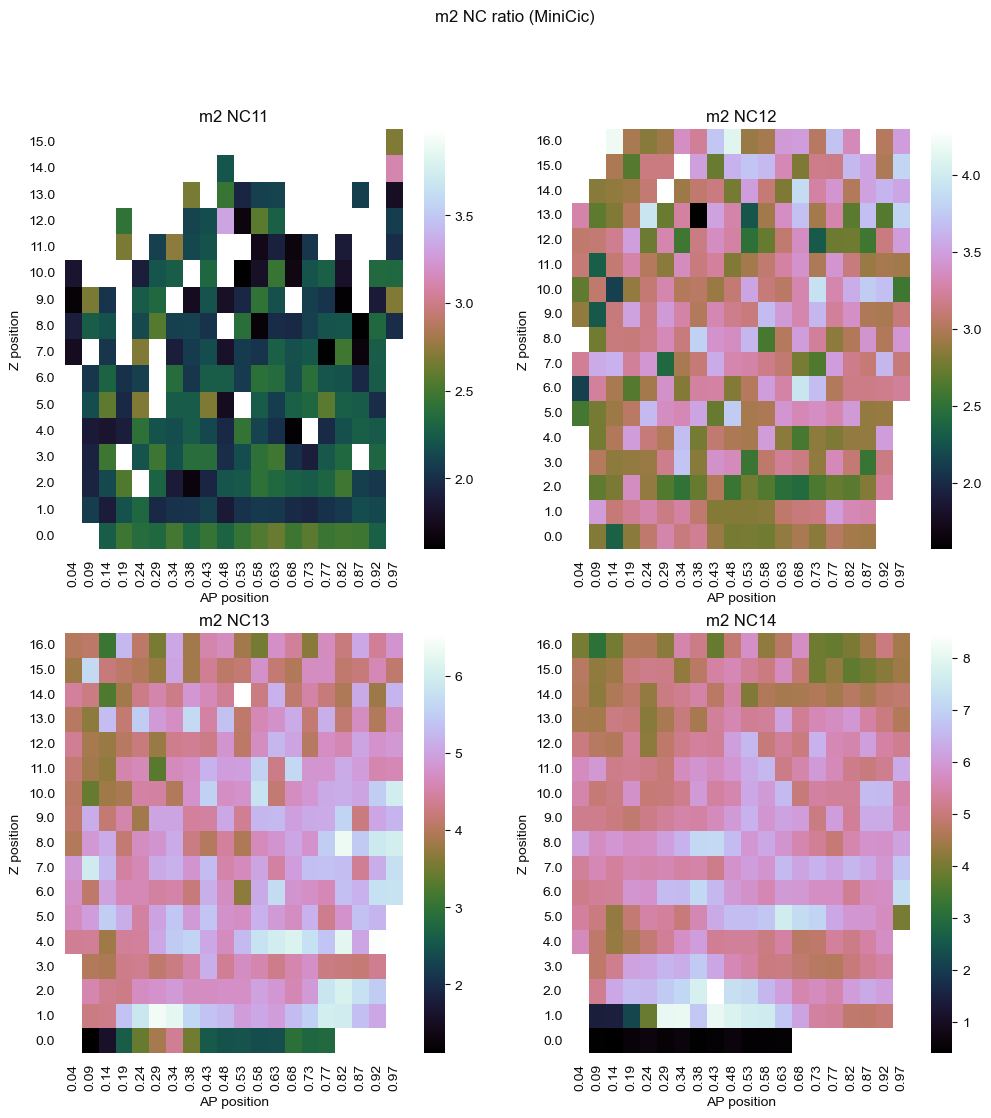

In [14]:

for root in roots:
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for nc, ax in zip(ncs, axes.flatten()):
        df = gated[(gated.root == root) & (gated.nc == nc)]
        mean_ratio = df.groupby(["binned_ap", "centroid z"])["Intensity Ratio"].mean()
        mean_ratio = mean_ratio.reset_index().pivot(index="binned_ap", columns="centroid z", values="Intensity Ratio")
        sns.heatmap(mean_ratio.T, ax=ax, cmap="cubehelix")
        ax.set_title(f"{root} {nc}")
        ax.set_xlabel("AP position")
        ax.set_ylabel("Z position")
        # print([f"{lab.__dict__}" for lab in ax.get_yticklabels()])
        ax.set_xticklabels([f"{float(lab._text):0.2f}" for lab in ax.get_xticklabels()])
        ax.invert_yaxis()
        
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for nc, ax in zip(ncs, axes.flatten()):
        df = gated[(gated.root == root) & (gated.nc == nc)]
        mean_ratio = df.groupby(["binned_ap", "centroid z"])["Erk Activity"].mean()
        mean_ratio = mean_ratio.reset_index().pivot(index="binned_ap", columns="centroid z", values="Erk Activity")
        sns.heatmap(mean_ratio.T, ax=ax, cmap="cubehelix")
        ax.set_title(f"{root} {nc}")
        ax.set_xlabel("AP position")
        ax.set_ylabel("Z position")
        # print([f"{lab.__dict__}" for lab in ax.get_yticklabels()])
        ax.set_xticklabels([f"{float(lab._text):0.2f}" for lab in ax.get_xticklabels()])
        ax.invert_yaxis()
        
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for nc, ax in zip(ncs, axes.flatten()):
        df = gated[(gated.root == root) & (gated.nc == nc)]
        sns.scatterplot(df, x="ap position", y="centroid z", hue="Intensity Ratio", ax=ax)
        
for root in roots:
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for nc, ax in zip(ncs, axes.flatten()):
        df = gated[(gated.root == root) & (gated.nc == nc)]
        mean_ratio = df.groupby(["binned_ap", "centroid z"])["NC ratio (MiniCic)"].mean()
        mean_ratio = mean_ratio.reset_index().pivot(index="binned_ap", columns="centroid z", values="NC ratio (MiniCic)")
        sns.heatmap(mean_ratio.T, ax=ax, cmap="cubehelix")
        ax.set_title(f"{root} {nc}")
        ax.set_xlabel("AP position")
        ax.set_ylabel("Z position")
        # print([f"{lab.__dict__}" for lab in ax.get_yticklabels()])
        ax.set_xticklabels([f"{float(lab._text):0.2f}" for lab in ax.get_xticklabels()])
        ax.invert_yaxis()
        
    plt.suptitle(f"{root} NC ratio (MiniCic)")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for nc, ax in zip(ncs, axes.flatten()):
        df = gated[(gated.root == root) & (gated.nc == nc)]
        mean_ratio = df.groupby(["binned_ap", "centroid z"])["NC ratio (HisGFP)"].mean()
        mean_ratio = mean_ratio.reset_index().pivot(index="binned_ap", columns="centroid z", values="NC ratio (HisGFP)")
        sns.heatmap(mean_ratio.T, ax=ax, cmap="cubehelix")
        ax.set_title(f"{root} {nc}")
        ax.set_xlabel("AP position")
        ax.set_ylabel("Z position")
        # print([f"{lab.__dict__}" for lab in ax.get_yticklabels()])
        ax.set_xticklabels([f"{float(lab._text):0.2f}" for lab in ax.get_xticklabels()])
        ax.invert_yaxis()
        
    plt.suptitle(f"{root} NC ratio (MiniCic)")
                
    # fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    # 
    # for nc, ax in zip(ncs, axes.flatten()):
    #     df = gated[(gated.root == root) & (gated.nc == nc)]
    #     mean_ratio = df.groupby(["binned_ap", "centroid z"])["Intensity Ratio"].size()
    #     mean_ratio = mean_ratio.reset_index().pivot(index="binned_ap", columns="centroid z", values="Intensity Ratio")
    #     sns.heatmap(mean_ratio, ax=ax, cmap="cubehelix")
    #     ax.set_title(f"{root} {nc}")
    #     ax.set_xlabel("Z position")
    #     ax.set_ylabel("AP position")
    #     # print([f"{lab.__dict__}" for lab in ax.get_yticklabels()])
    #     ax.set_yticklabels([f"{float(lab._text):0.2f}" for lab in ax.get_yticklabels()], rotation=0)

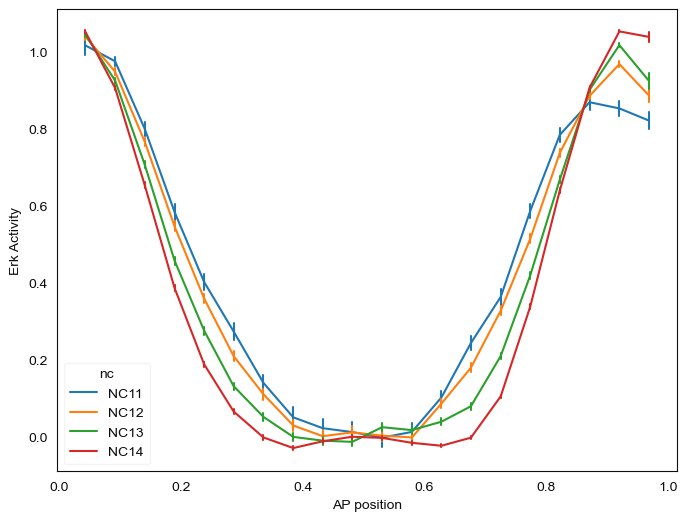

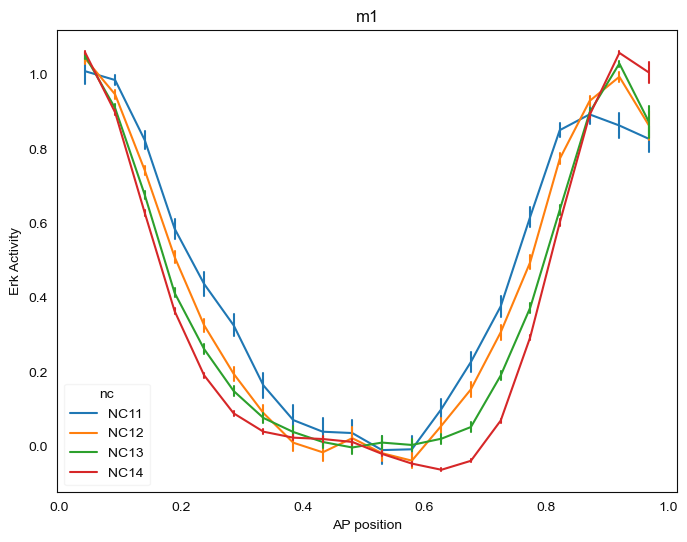

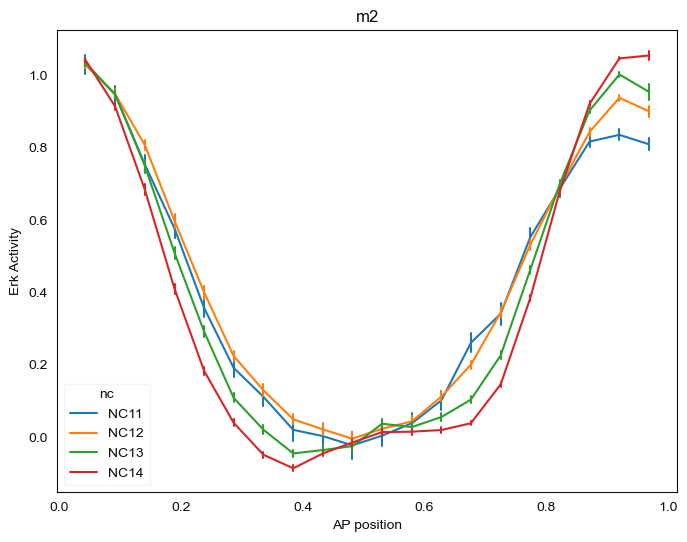

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(gated, x="binned_ap", y="Erk Activity", hue="nc", err_style="bars", errorbar="se")
plt.xlabel("AP position")
# plt.ylabel("Intensity ratio")
plt.savefig(datapath / "erk_activity.png", dpi=300)
plt.show()

for root in roots:
    fig, ax = plt.subplots(figsize=(8, 6))
    df = gated[gated.root == root]
    sns.lineplot(df, x="binned_ap", y="Erk Activity", hue="nc", err_style="bars", errorbar="se")
    plt.xlabel("AP position")
    plt.title(root)
    plt.savefig(datapath / root / f"erk_intensity.png", dpi=300)
    plt.show()

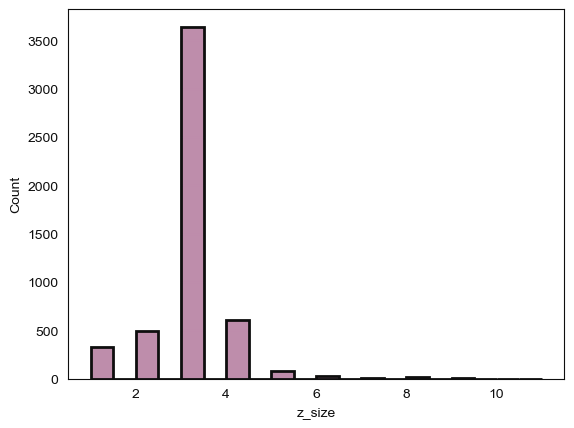

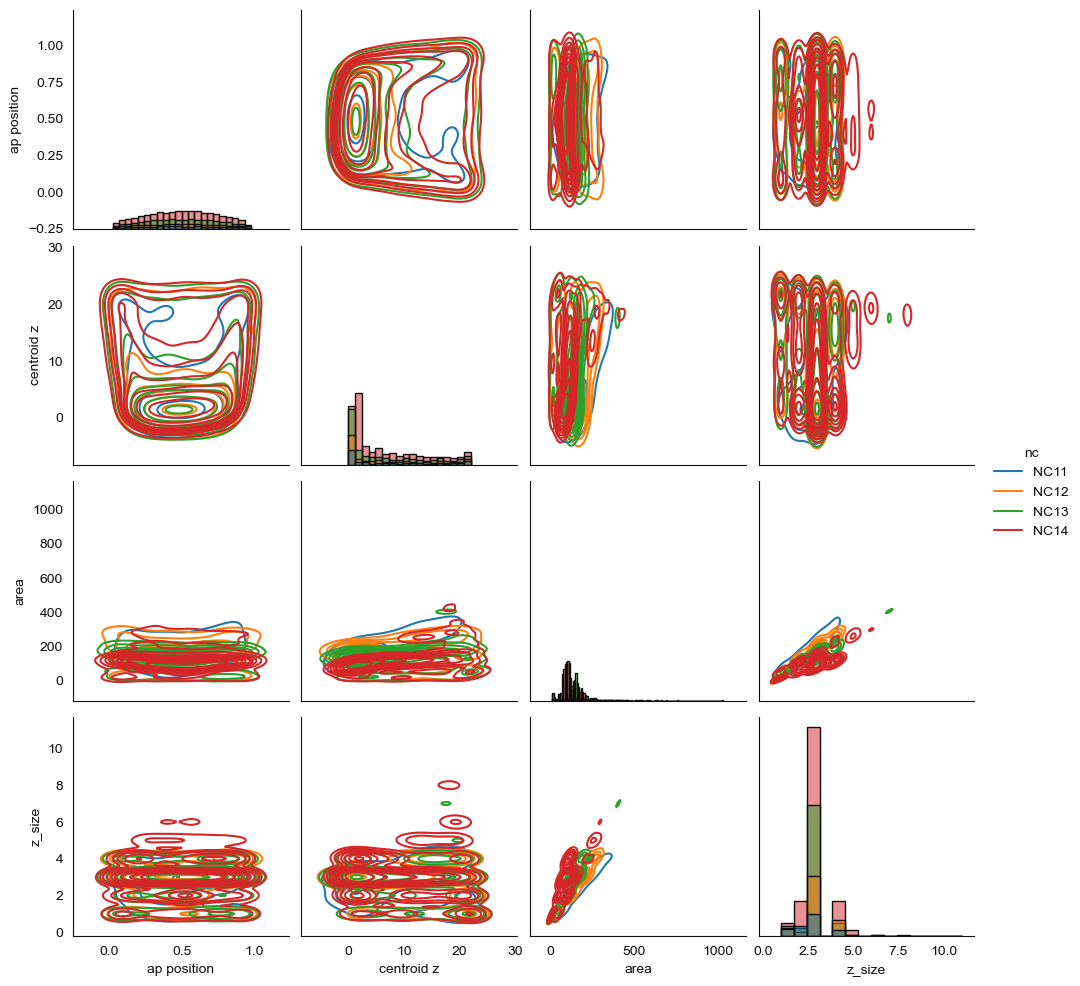

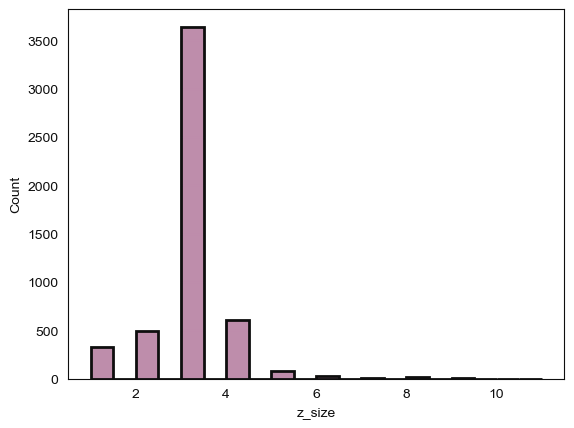

KeyboardInterrupt: 

In [24]:
root = "m1"
df = dfs[root]

for root in roots:

    df["z_size"] = df["bbox-3"] - df["bbox-0"]
    sns.histplot(df, x="z_size", bins=20, color=s_palette(0.5), edgecolor=palette["black"], linewidth=2)
    plt.show()
    
    sns.pairplot(df, vars=["ap position", "centroid z", "area", "z_size"], 
                 diag_kind="hist", diag_kws={"edgecolor": palette["black"], "linewidth": 1},
                    kind="kde", hue="nc", corner=True)
    plt.show()

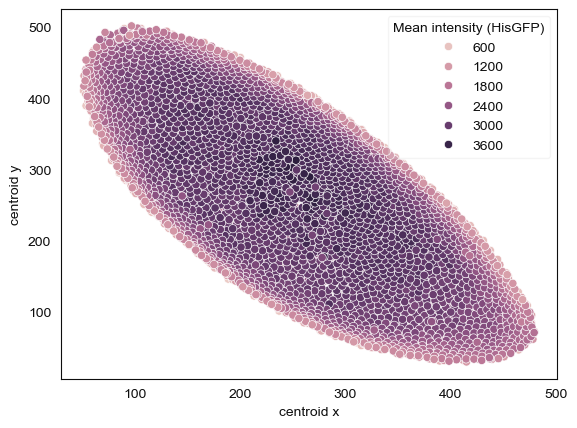

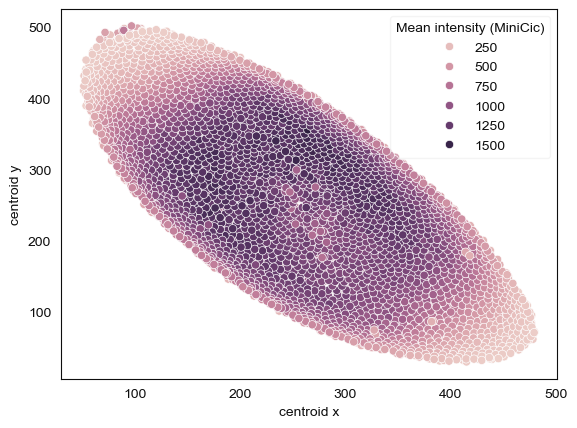

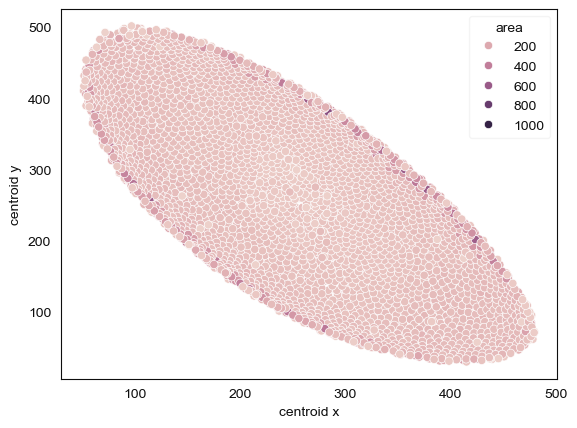

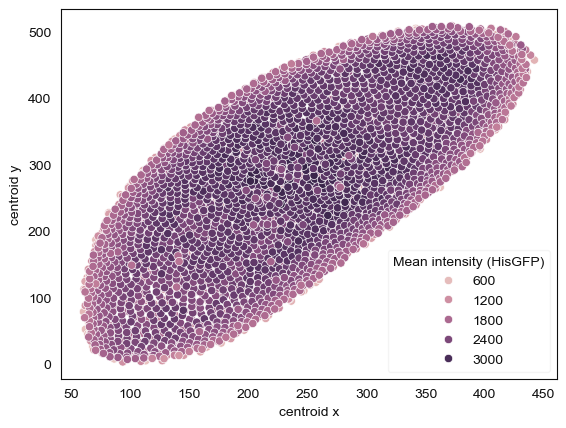

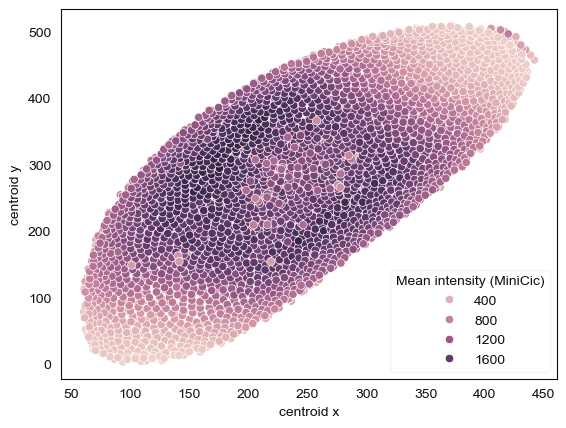

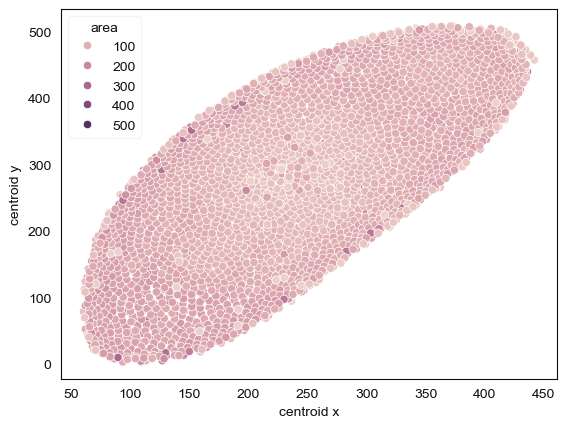

In [18]:
for root in roots:
    df = dfs[root]
    
    sns.scatterplot(df, x="centroid x", y="centroid y", hue="Mean intensity (HisGFP)")
    plt.savefig(datapath / root / "hisgfp_scatter.png", dpi=300)
    plt.show()
    
    sns.scatterplot(df, x="centroid x", y="centroid y", hue="Mean intensity (MiniCic)")
    plt.savefig(datapath / root / "minicic_scatter.png", dpi=300)
    plt.show()
    
    sns.scatterplot(df, x="centroid x", y="centroid y", hue="area")
    plt.savefig(datapath / root / "area_scatter.png", dpi=300)
    plt.show()

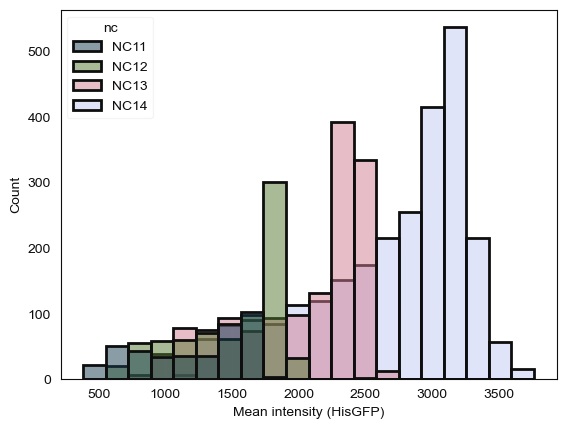

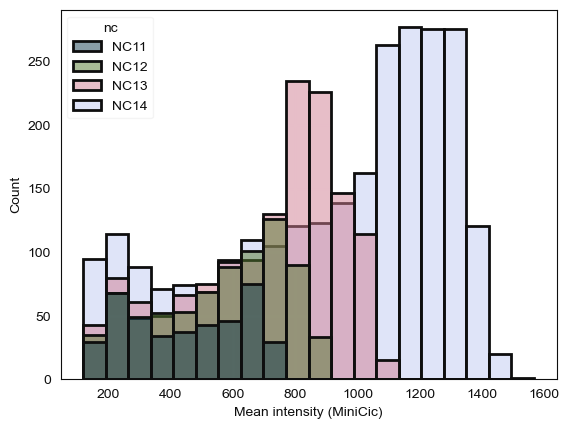

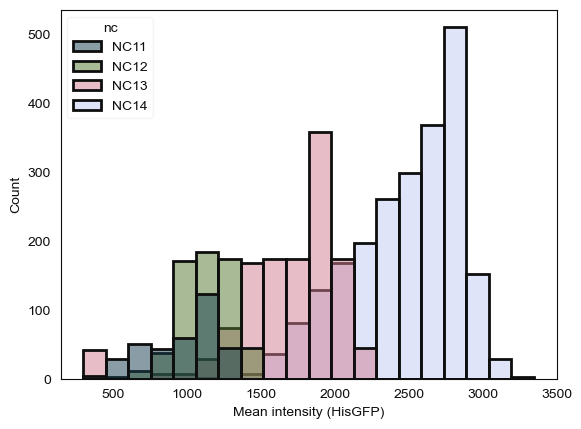

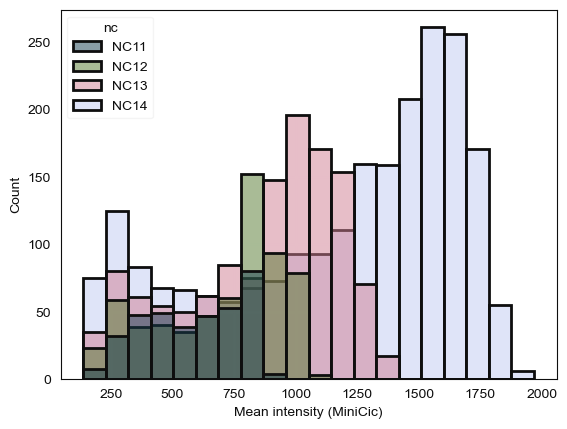

In [21]:
for root in roots:
    df = dfs[root]

    sns.histplot(df, x="Mean intensity (HisGFP)", bins=20, palette="cubehelix", hue="nc", edgecolor=palette["black"], linewidth=2)
    plt.xlabel("Mean intensity (HisGFP)")
    plt.savefig(datapath / root / "hisgfp_hist.png", dpi=300)
    plt.show()
    sns.histplot(df, x="Mean intensity (MiniCic)", bins=20, palette="cubehelix", hue="nc", edgecolor=palette["black"], linewidth=2)
    plt.xlabel("Mean intensity (MiniCic)")
    plt.savefig(datapath / root / "minicic_hist.png", dpi=300)
    plt.show()

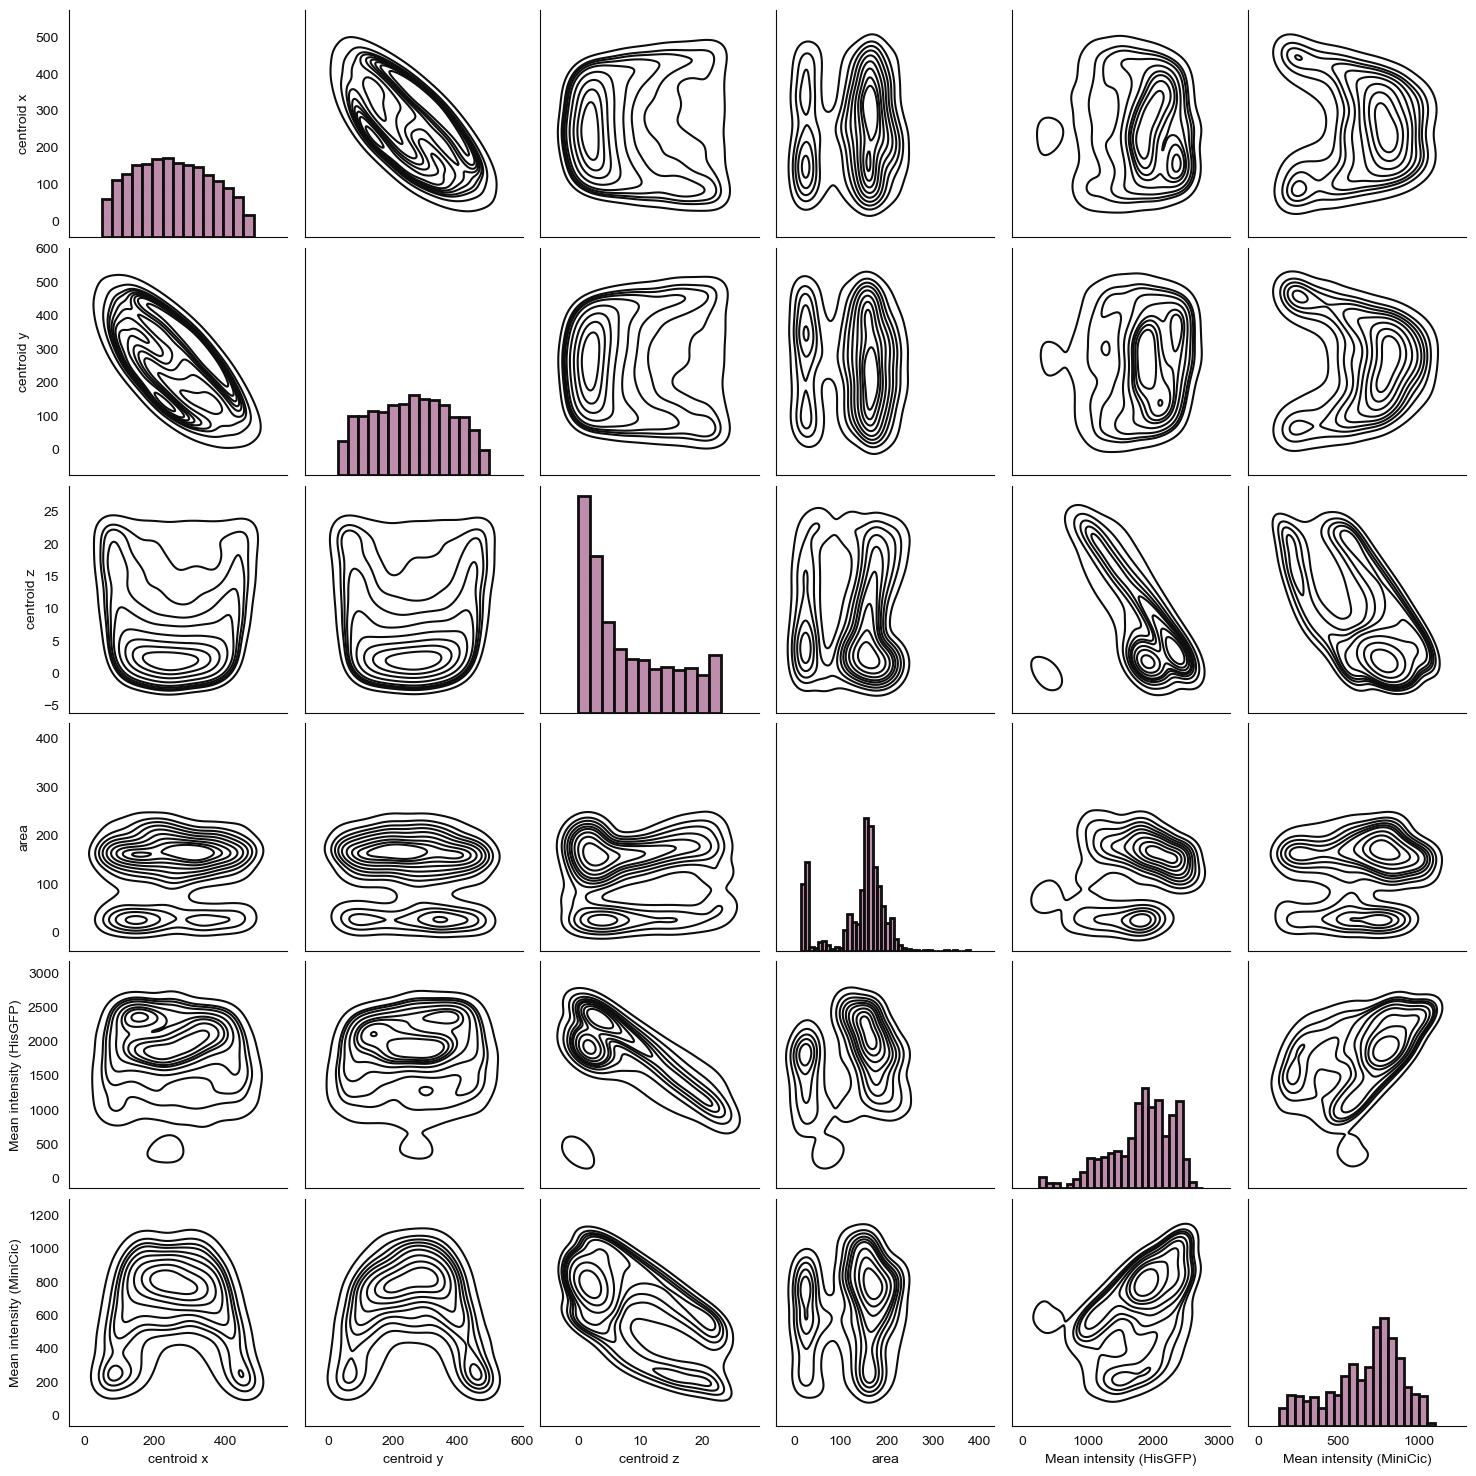

In [32]:
sns.pairplot(df, vars=["centroid x", "centroid y", "centroid z", "area", "Mean intensity (HisGFP)", "Mean intensity (MiniCic)"], 
             diag_kind="hist", diag_kws={"color": s_palette(0.5), "edgecolor": palette["black"], "linewidth": 2},
             kind="kde", plot_kws={"color": palette["black"]})
plt.savefig(datapath / "pairplot.png", dpi=300)
plt.show()

In [47]:
gated = df[df.area > 80].copy()
gated = gated[gated["Mean intensity (HisGFP)"] > 800].copy()
# sns.pairplot(gated, vars=["centroid x", "centroid y", "centroid z", "area", "Mean intensity (HisGFP)", "Mean intensity (MiniCic)"], 
#              diag_kind="hist", diag_kws={"color": s_palette(0.5), "edgecolor": palette["black"], "linewidth": 2},
#              kind="kde", plot_kws={"color": palette["black"]})

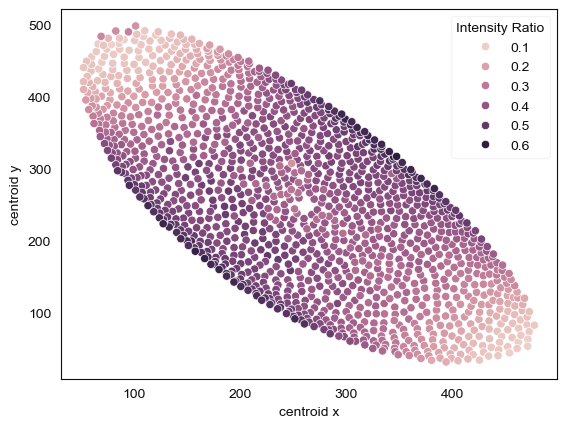

In [48]:
gated["Intensity Ratio"] = gated["Mean intensity (MiniCic)"] / gated["Mean intensity (HisGFP)"]
sns.scatterplot(gated, x="centroid x", y="centroid y", hue="Intensity Ratio")
plt.savefig(datapath / "ratio_scatter.png", dpi=300)
plt.show()

In [64]:
px, py = 58, 490
ax, ay = 480, 40

x, y = gated["centroid x"] - ax, gated["centroid y"] - ay
x_ref, y_ref = px - ax, py - ay

gated["ap position"] = (x * x_ref + y * y_ref) / (x_ref ** 2 + y_ref ** 2)

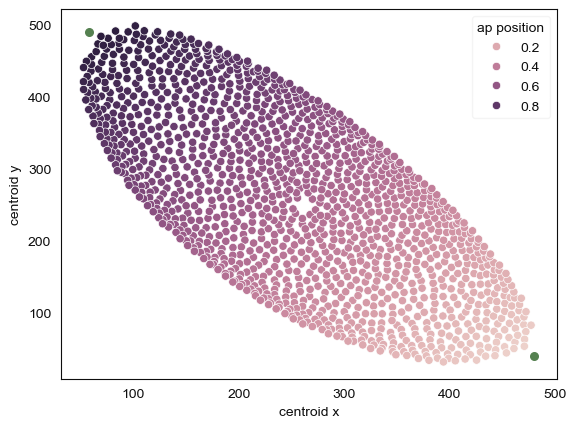

In [65]:
sns.scatterplot(gated, x="centroid x", y="centroid y", hue="ap position")
plt.scatter([ax, px], [ay, py], color=palette["green"], s=30)
plt.savefig(datapath / "ap_axis.png", dpi=300)

binned_ap
0.51250    39
0.45550    38
0.56950    37
0.39850    37
0.47450    37
0.53150    36
0.55050    36
0.60800    35
0.32150    35
0.37900    35
0.41750    35
0.43650    35
0.34050    35
0.64650    34
0.30250    34
0.58850    34
0.35950    34
0.68450    33
0.70350    33
0.49350    33
0.74150    30
0.26450    30
0.62750    29
0.24550    29
0.66550    29
0.28350    28
0.77950    28
0.20750    28
0.83700    27
0.79850    27
0.18850    26
0.72250    25
0.76050    25
0.22650    24
0.11150    23
0.81750    23
0.16900    23
0.14950    22
0.87550    22
0.85650    20
0.89450    20
0.13050    19
0.91350    15
0.07355    15
0.09255    14
0.93250    14
0.95150    14
0.05450    12
0.03495     6
0.97050     6
Name: count, dtype: int64


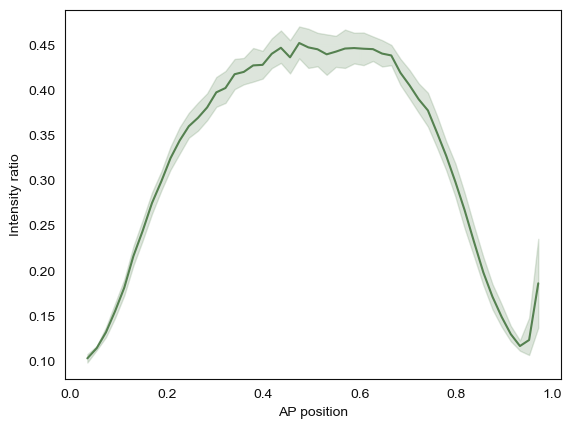

In [66]:
gated["binned_ap"] = [(i.left + i.right)/2 for i in pd.cut(gated["ap position"], bins=50)]
print(gated["binned_ap"].value_counts())

sns.lineplot(x=gated["binned_ap"], y=gated["Intensity Ratio"], color=palette["green"])
plt.xlabel("AP position")
plt.ylabel("Intensity ratio")
plt.savefig(datapath / "ap_intensity.png", dpi=300)